In [90]:
# Initialize Otter
import otter
grader = otter.Notebook("cs1090a_hw2.ipynb")

# CS1090A Introduction to Data Science
## Homework 2: kNN, Linear/Polynomial Regression, Regularization, and Model Selection

**Harvard University**<br/>
**Fall 2025**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Gumb

<hr style="height:2.4pt">

In [91]:
# RUN THIS CELL 
from IPython.core.display import HTML

# Define custom CSS for the notebook
styles = """
<style>
    h2, h3, h4 {
        color: black;
        border: 1px solid #e0e0e0;
        border-radius: 5px;
        padding: 10px 15px;
        margin-top: 20px;
        margin-bottom: 10px;
        font-weight: bold;
    }
    h2 { background-color: #C8A2C8; } /* Lilac */
    h3 { background-color: #D8BFD8; } /* Thistle */
    h4 { background-color: #E6E6FA; } /* Lavender */
</style>
"""
HTML(styles)

### Import Libraries

In [92]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
import time

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

from warnings import simplefilter
simplefilter('ignore', category=FutureWarning)

In [93]:
# For calculating total notebook runtime
notebook_start = time.time()

## About this homework

This assignment is the first in which we'll go through the full process of loading a dataset, performing exploratory data analysis (EDA), splitting the data into training, validation, and test sets, and finally fitting and evaluating models. You can use the table of contents panel in your Jupyter environment (e.g., JupyterLab or Colab) to navigate between sections.

The homework is divided into three parts, each using a different dataset:

-   **Part 1: Predicting Car Prices**
    Explore two fundamental modeling techniques: k-Nearest Neighbors (kNN) regression, a non-parametric method, and simple linear regression, a parametric method. Use a validation set to tune the hyperparameter `k` for the kNN model.

-   **Part 2: Analyzing Simulated Income Data**
    Practice exploratory data analysis (EDA) and data critique. Create insightful visualizations to explore relationships in a simulated US census dataset and calculate the Gini coefficient to measure income inequality.

-   **Part 3: Modeling Bacteria Growth**
    Dive deeper into model selection and the bias-variance tradeoff. Using polynomial regression, explore how model complexity (the degree of the polynomial) impacts performance. Compare two common techniques for hyperparameter tuning and model selection—using a single validation set versus k-fold cross-validation—to find a model that generalizes well and avoids overfitting.

<div style="background-color: #E6E6FA; color: black; border: 1px solid #e0e0e0; border-radius: 5px; padding: 10px 15px;">

### Instructions

**Submission Checklist**
- **Run All Cells:** Before submitting, always do **"Restart Kernel and Run All Cells"** to ensure your notebook runs top-to-bottom without errors and all output is visible.
- **Submission:** Follow the submission instructions described in the Canvas assignment.

**General Guidelines**
- **Limit Output:** Avoid excessively long cell outputs.
- **Clarity:** Plots must be legible and well-labeled. Written interpretations should explain what the results *mean*, not just describe them.
- **Code Quality:** Write clean and efficient code. Avoid copy-pasting; use loops or functions instead.
- **Libraries:** Use only the provided libraries unless you get staff approval.
- **Autograding:** The provided tests are not exhaustive. Passing all tests does not guarantee full credit.
- **Cell Management:** Feel free to add new cells as needed.

</div>

<a id="part1"></a>
    
# PART 1 [35 pts]: Predicting the selling price of cars on CarDekho.com

<a id="part1intro"></a>

## Overview

According to its website, **CarDekho.com** is India's leading car search venture. Its website and app carry rich automotive content such as expert reviews, detailed specs and prices, comparisons, as well as videos and pictures of all car brands and models available in India. Each car has a **current selling price**, which is the price for buying a used car on this site, and an **MRP**, which is the retail price of the car. These two prices differ depending on factors such as brand, make year, mileage, condition, etc.  

### Dataset 

The dataset contains 601 used cars and is available as `data/car_dekho_full.csv`. It contains the following columns:

- **Year** - make year (year the car was made), 
- **Current_Selling_Price** - current price of a used car on CarDekho.com (in lakhs),
- **MRP** - maximum retail price of the car when it was new (in lakhs). 
- **Kms_Driven** - number of kilometers

**NOTE:** 1 *lakh*  is 100,000 Rupees in the Indian numbering system. Also, kilometers are used as a measure of distance instead of miles.

### Objective

Using kNN and linear regression we will predict the `Current_Selling_Price` from the other features available in this dataset.

<a id="part1questions"></a>

## Question 1: Exploratory data analysis (EDA) [5 pts]

To reach the goal of predicting the `Current_Selling_Price`, start by inspecting the dataset using Exploratory Data Analysis (EDA).

**Load the dataset, inspect it, and answer the following questions:**

<!-- BEGIN QUESTION -->

### Q1.1

Identify all variables in the dataset. For each variable, state whether you consider it to be quantitative or categorical and briefly justify your choices.

KMS_Driven, MRP, Current_Selling_Price can be considered quantitative variables as they represent measurable quantities.
Year could also be quantitative, but for the dataset I will consider it as categorical, as it can be used as a label for cars in a generation.

In [94]:
# your code here
import os

def import_data(filename):
    """
    Imports data from a CSV file into a pandas DataFrame.
    
    Parameters:
    filename (str): The name of the CSV file to import.
    
    Returns:
    pd.DataFrame: The imported data as a pandas DataFrame.
    """
    if not os.path.isfile(os.path.join("./data/", filename)):
        raise FileNotFoundError(f"The file {filename} does not exist.")
    
    try:
        data = pd.read_csv(os.path.join("./data/", filename))
        return data
    except Exception as e:
        raise IOError(f"An error occurred while reading the file {filename}: {e}")
    
df_car = import_data('car_dekho_full.csv')

df_car.head()

,Year,Current_Selling_Price,MRP,Kms_Driven
0,2016,5.25,5.70,3493
1,2005,3.51,13.70,75000
2,2010,0.31,1.05,213000
3,2006,2.10,7.60,50456
4,2005,0.20,0.57,55000


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q1.2

The goal in this section is to identify the best feature to use to predict our response, `Current_Selling_Price`. 

- Plot a scatter plot of each feature and our reponse and examine any relationships.
- Which is the predictor that seems to best predict `Current_Selling_Price`? Provide an interpretation of the plots that justifies your choice.

The predictor that seems a better option to predict Current_Selling_Price is MRP. The scatter plot of MRP vs Current_Selling_Price shows positive correlation, indicating that as the MRP increases, the Current_Selling_Price also tends to increase. This suggests that cars with a higher original retail price tend to retain more value when sold as used cars, since depreciation is proportional to the original cost. 
In contrast, the scatter plot of Kms_Driven vs Current_Selling_Price shows a negative correlation, but it is more scattered, while higher mileage may lead to a lower selling price, the relationship is not as strong or consistent as with MRP.
The Year variable, being categorical, does not show a clear trend in relation to Current_Selling_Price, making it less useful for prediction in this context.

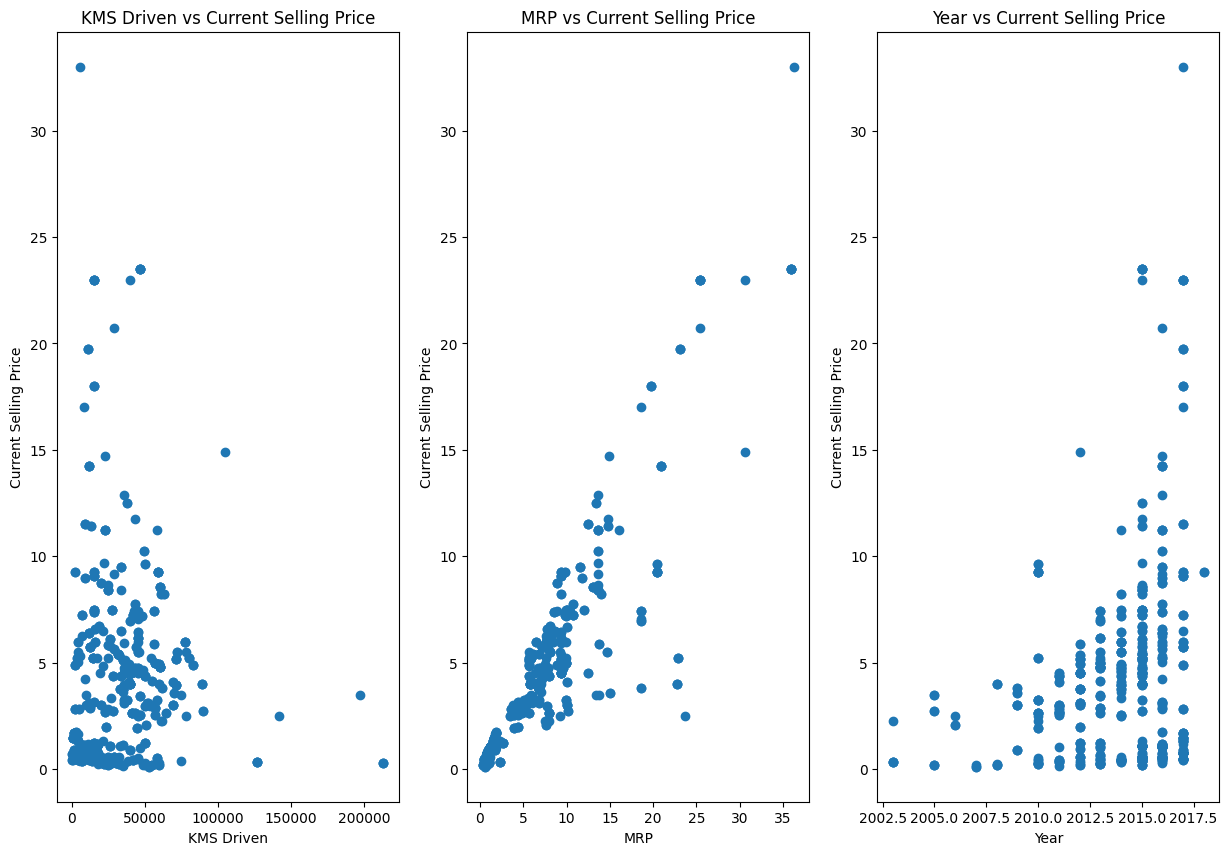

In [95]:
fig2, axCarDekho = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

axCarDekho[0].scatter(data=df_car, x='Kms_Driven', y='Current_Selling_Price')
axCarDekho[0].set_title('KMS Driven vs Current Selling Price')
axCarDekho[0].set_xlabel('KMS Driven')
axCarDekho[0].set_ylabel('Current Selling Price')
axCarDekho[1].scatter(data=df_car, x='MRP', y='Current_Selling_Price')
axCarDekho[1].set_title('MRP vs Current Selling Price')
axCarDekho[1].set_xlabel('MRP')
axCarDekho[1].set_ylabel('Current Selling Price')
axCarDekho[2].scatter(data=df_car, x='Year', y='Current_Selling_Price')
axCarDekho[2].set_title('Year vs Current Selling Price')
axCarDekho[2].set_xlabel('Year')
axCarDekho[2].set_ylabel('Current Selling Price') 

plt.show()


# your code here

<!-- END QUESTION -->

<a id="part2questions"></a>

## Question 2: k-Nearest Neighbors [14 pts]

We will begin our modeling with k-Nearest Neighbors (kNN) regression, using `sklearn` for both preprocessing and model fitting.

### Q2.1

Split the dataset into a train, validation, and test set with 60% training data, 20% validation data, and 20% testing data, using argument `random_state = 109`.

The resulting splits should be stored in the variables:

- `X_train_and_val`, `X_test`, `y_train_and_val`, `y_test` (from the first split)  
- `X_train`, `X_val`, `y_train`, `y_val` (from the second split)

In [96]:
random_state = 109
#Test split 60% train, 20% val, 20% test
X_train_and_val, X_test, y_train_and_val, y_test = train_test_split( df_car[['Kms_Driven', 'MRP', 'Year']], df_car['Current_Selling_Price'], test_size=0.2, random_state=random_state)
#Validation split 75% train, 25% val from the 80% train to get 60% train, 20% val
X_train, X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val, test_size=0.25, random_state=random_state)





In [97]:
grader.check("q2.1")

q2.1 results: All test cases passed!

### Q2.2

Now, we will fit several kNN regression models for various values of $k$ to identify the best parameterization.

<!-- BEGIN QUESTION -->

#### Q2.2.1

For each $k$ in $k \in [1,2,3,5,7,10,50,100]$, fit a k-NN regression model to the training data with response `Current_Selling_Price` and the predictor `MRP`. 
  - For each $k$, make a plot of reponse vs. predictor (8 plots in total, arranged in a 4×2 grid). 
  - Each of your 8 plots should clearly show (a) the training data and the validation data in different colors, (b) the model prediction, and (c) title, legend, and axis labels.
  - **NOTE:** Feel free to use the `plt.subplots()` code we provide to specify your 4x2 grid, unless you first try that and decide that you have a clearer, cleaner way of accomplishing this task.

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/pytho

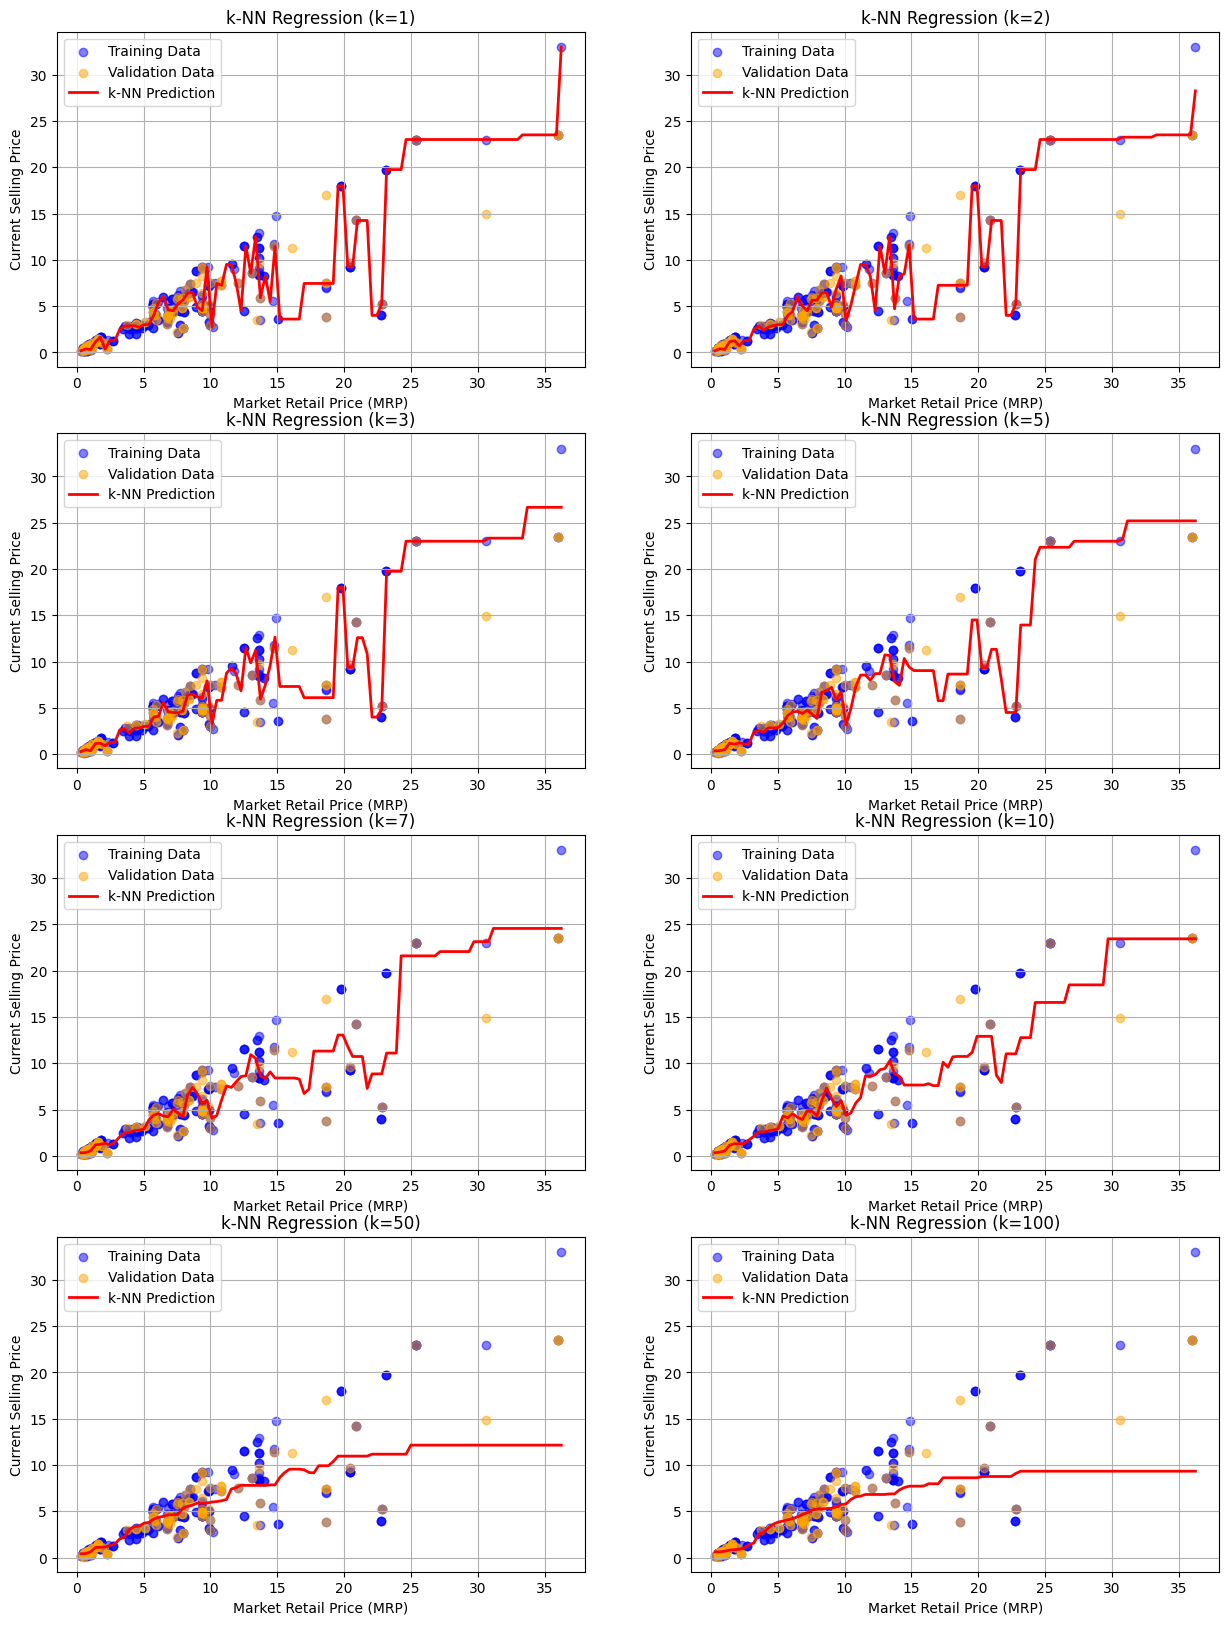

In [98]:
def plot_knn_regression(k, X_train, y_train, X_val, y_val, fig, ax):

    
    ax.scatter(X_train['MRP'], y_train, color='blue', label='Training Data', alpha=0.5)
    ax.scatter(X_val['MRP'], y_val, color='orange', label='Validation Data', alpha=0.5)
    
    # Create a range of MRP values for prediction
    mrp_range = np.linspace(X_train['MRP'].min(), X_train['MRP'].max(), 100).reshape(-1, 1)
    y_pred_range = knn.predict(mrp_range)

    ax.plot(mrp_range, y_pred_range, color='red', label='k-NN Prediction', linewidth=2)

    ax.set_title(f'k-NN Regression (k={k})')
    ax.set_xlabel('Market Retail Price (MRP)')
    ax.set_ylabel('Current Selling Price')
    ax.legend()
    ax.grid()

    return ax

#For each $k$ in $k \in [1,2,3,5,7,10,50,100]$, fit a k-NN regression model to the training data with response `Current_Selling_Price` and the predictor `MRP`. 

fig, axes = plt.subplots(4, 2, figsize=(15, 20))
Ks = [1,2,3,5,7,10,50,100]
train_MSEs = []
val_MSEs = []

for i, k in enumerate(Ks):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train[['MRP']], y_train)
    y_val_pred = knn.predict(X_val[['MRP']])

    mse_train = mean_squared_error(y_train, knn.predict(X_train[['MRP']]))
    train_MSEs.append(mse_train)
    mse_val = mean_squared_error(y_val, y_val_pred)
    #print(f'k={k}, Validation MSE: {mse_val:.2f}')
    val_MSEs.append(mse_val)

    ax = axes[i//2, i%2]
    plot_knn_regression(k, X_train, y_train, X_val, y_val, fig, ax)



<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### Q2.2.2

Plot the training and validation $MSE$ values as a function of $k$ (1 plot in total).

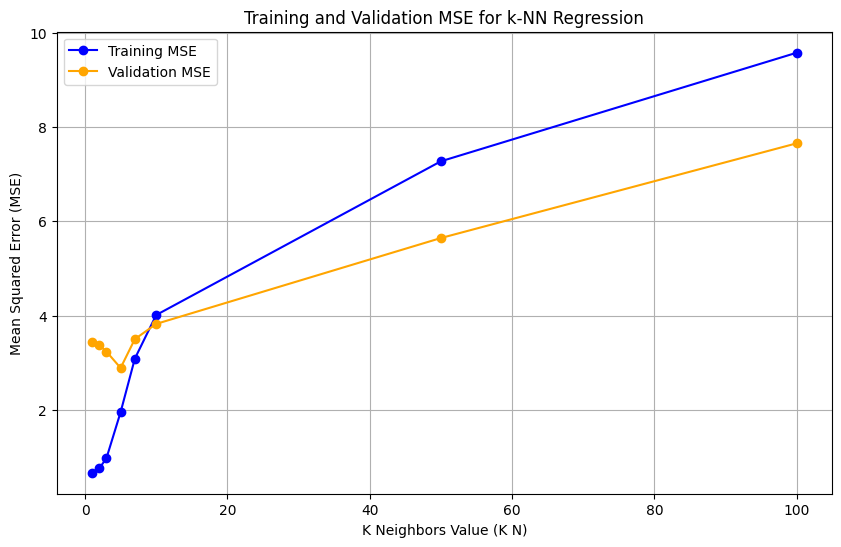

In [99]:
fig2, axMSEs = plt.subplots(figsize=(10, 6))
axMSEs.plot(Ks, train_MSEs, marker='o', label='Training MSE', color='blue')
axMSEs.plot(Ks, val_MSEs, marker='o', label='Validation MSE', color='orange')
axMSEs.set_xlabel('K Neighbors Value (K N)')
axMSEs.set_ylabel('Mean Squared Error (MSE)')
axMSEs.set_title('Training and Validation MSE for k-NN Regression')
axMSEs.legend()
axMSEs.grid()

<!-- END QUESTION -->

#### Q2.2.3

Find the best model based on the validation $MSE$ values. Store the best $k$-value in `best_k` and the best validation $MSE$ in `best_mse`.

In [100]:
# your code here
best_k = 7
best_mse = val_MSEs[Ks.index(best_k)]

In [101]:
print(
    f"The best k value is {best_k}. This corresponds to the "
    f"lowest validation MSE of {best_mse:.3f}."
)

The best k value is 7. This corresponds to the lowest validation MSE of 3.501.


In [102]:
grader.check("q2.2.3")

q2.2.3 results: All test cases passed!

#### Q2.2.4

Now that you've chosen your best k, fit your final model and report the test $R^2$. Save the result in `best_r2`. **Hint:** why might you need to fit the model again before evaluating on the test set?

In [103]:
# your code here
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(X_train[['MRP']], y_train)
y_test_pred = knn.predict(X_test[['MRP']])

mse_test = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)


best_r2 = r2
knn_test_mse = mse_test

In [104]:
print(
    f"The R-squared score evaluated on the test set for the best model "
    f"with k={best_k} is {best_r2:.4f}."
    f"\nThe test MSE is {knn_test_mse:.4f}."
)

The R-squared score evaluated on the test set for the best model with k=7 is 0.8416.
The test MSE is 2.2109.


In [105]:
grader.check("q2.2.4")

q2.2.4 results: All test cases passed!

<a id="part3questions"></a>

## Question 3: Simple linear regression [16 pts]

### Q3.1

We will now fit our data using a linear regression model. Choose the same **predictor** and **response** variables you used in the kNN model. Use a 75% training and 25% testing split of the data, using `random_state = 109`.

For a fair comparison with the kNN model, we will use the same train/test split from Q2.
Since our simple linear regression model does not require a validation set for hyperparameter tuning, we can train it on the combined training and validation data.

In [106]:
X_train, y_train = X_train_and_val, y_train_and_val

The variables X_test and y_test are already defined from the split in Q2.1 and will be used for testing.

#### Q3.1.1

Fit a linear regression model. Name your model `linreg`.

In [107]:
# your code here
# Instantiate a LinearRegression class object and fit with train data
linreg = LinearRegression()
linreg.fit(X_train[['MRP']], y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [108]:
grader.check("q3.1.1")

q3.1.1 results: All test cases passed!

#### Q3.1.2

Report the slope and intercept values for the fitted linear model. Name your variables `slope` and `intercept`.

In [109]:
# your code here
slope = linreg.coef_[0]
intercept = linreg.intercept_

In [110]:
print(
    f"Intercept of the fitted linear model\t\t{intercept:.4f}\n"
    f"Slope of the fitted linear model\t{slope:.4f}"
)

Intercept of the fitted linear model		0.0666
Slope of the fitted linear model	0.6261


In [111]:
grader.check("q3.1.2")

q3.1.2 results: All test cases passed!

#### Q3.1.3

Report the $MSE$ for the training and test sets and the $R^2$ for the test set. Name your variables `lin_train_mse`, `lin_test_mse`, and `lin_test_r2`.

In [112]:
# your code here 
#Compute the MSE of the model
lin_train_mse = mean_squared_error(y_train, linreg.predict(X_train[['MRP']]))
lin_val_mse = mean_squared_error(y_val, linreg.predict(X_val[['MRP']]))
lin_test_mse = mean_squared_error(y_test, linreg.predict(X_test[['MRP']]))
#Compute the R-squared of the model
lin_test_r2 = r2_score(y_test, linreg.predict(X_test[['MRP']]))

In [113]:
print("Linear regression model results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        lin_train_mse,
        lin_test_mse,
    )
)

print(f"\tTest R-squared\t{lin_test_r2:.4f}")

Linear regression model results:

	Train MSE	4.6718
	Test MSE	2.9148

	Test R-squared	0.7911


In [114]:
grader.check("q3.1.3")

q3.1.3 results: All test cases passed!

<!-- BEGIN QUESTION -->

#### Q3.1.4

Create the following 3 plots:
- Plot the **regression line** along with the **training data**.
- Plot the **residuals** of the model on the **training** set as a function of the **predictor** variable. Draw a horizontal line denoting the zero residual value on the $y$-axis.
- Plot a the **distribution** of the **residuals** on the **training** set.

As always, your plots should be well-labeled.

Text(0, 0.5, 'Frequency')

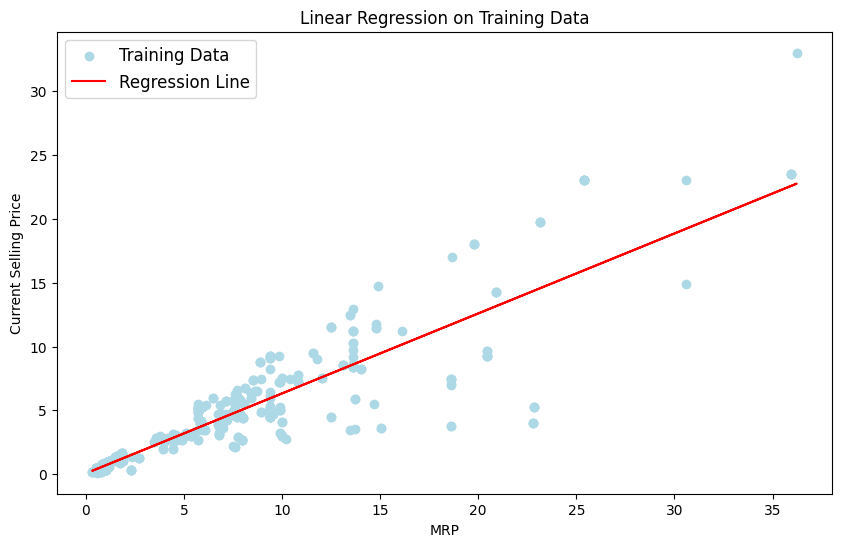

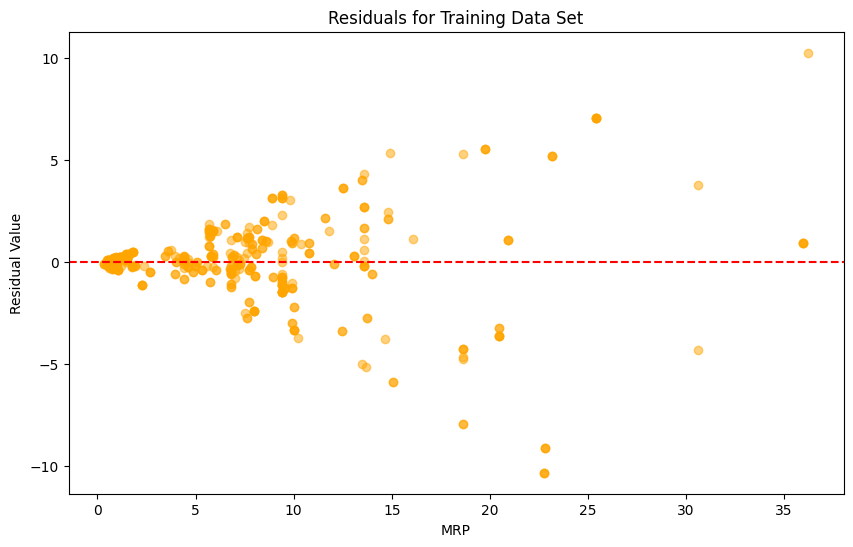

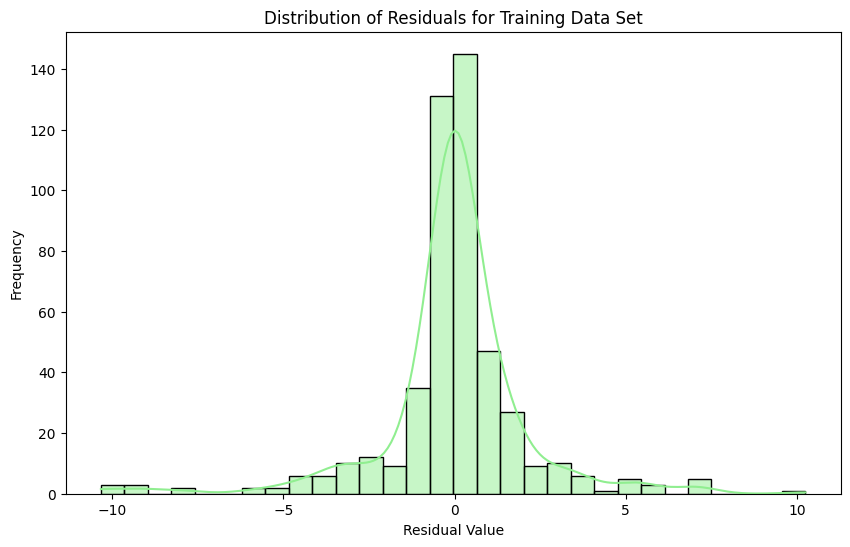

In [115]:
# your code here 
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(X_train['MRP'], y_train, color='lightblue', label='Training Data')
ax.legend(loc='upper left', fontsize=12, frameon=True)
ax.plot(X_train['MRP'], linreg.predict(X_train[['MRP']]), color='red', label='Regression Line')
ax.legend(loc='upper left', fontsize=12, frameon=True)
ax.set_title('Linear Regression on Training Data')
ax.set_xlabel('MRP')
ax.set_ylabel('Current Selling Price')

fig, ax = plt.subplots(figsize=(10, 6))
residuals = y_train - linreg.predict(X_train[['MRP']])
ax.scatter(X_train['MRP'], residuals, color='orange', alpha=0.5)
ax.axhline(0, color='red', linestyle='--', label='Zero Residual Line')
ax.set_title('Residuals for Training Data Set')
ax.set_xlabel('MRP')
ax.set_ylabel('Residual Value')

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, ax=ax, color='lightgreen')
ax.set_title('Distribution of Residuals for Training Data Set')
ax.set_xlabel('Residual Value')
ax.set_ylabel('Frequency')


<!-- END QUESTION -->

### Q3.2
Answer the following questions about your results:

<!-- BEGIN QUESTION -->

#### Q3.2.1

A linear regression model makes four important assumptions. For each assumption, describe how one or more of the plots in the previous question may provide evidence that (1) the assumption holds, (2) the assumption is violated, or (3) the plots do not provide enough evidence. In the latter case, suggest an additional diagnostic plot(s) or test(s) that could be used to evaluate the assumption.

# Linear regression assumptions:
1. Linearity: The relationship between the predictor and response is linear. The regression line plot shows a linear trend, this suggests that the linearity assumption is met.
2. Independence: The residuals are not independent. The residuals of training data set show a funnel shape when plotted against the predictor variable instead of a random scatter as the MRP increases, the variance of the residuals also increases, heteroscedasticity is present, indicating that the independence assumption is violated. A QQ plot of the residuals could be used to further evaluate this assumption.
3. Homoscedasticity: As mentioned above, the residuals show heteroscedasticity, which is the oposite of homoscedasticity, low variance at low values of MRP and high variance at high values of MRP, indicating that the homoscedasticity assumption is violated.
4. Normality: The residuals appear to be normally distributed, as the histogram of the residuals shows a bell-shaped curve, suggesting that the normality assumption is reasonably met.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

 
#### Q3.2.2
Based on your findings in Q3.2.1, identify the most significant assumption violation. Propose and implement a modified linear regression model that is designed to address this specific issue. Fit your new model and report its train and test MSE. In your explanation, justify why this modeling adjustment is appropriate for the violation you observed.

The most significant assumption violation is the homoscedasticity, as the residuals show a clear pattern of increasing variance with increasing MRP values. To address this issue, a common technique is to transform the dependent variable logarithmically to help stabilize the variance of the residuals, making the homoscedasticity assumption more tenable. Log transformation compresses the scale of the response variable, reducing the impact of large values.


Log-transformed linear regression model results:

	Train MSE	0.5129
	Test MSE	0.5079
 	Train R-squared	0.6427
 	est R-squared	0.6137



Text(0, 0.5, 'Residual Value')

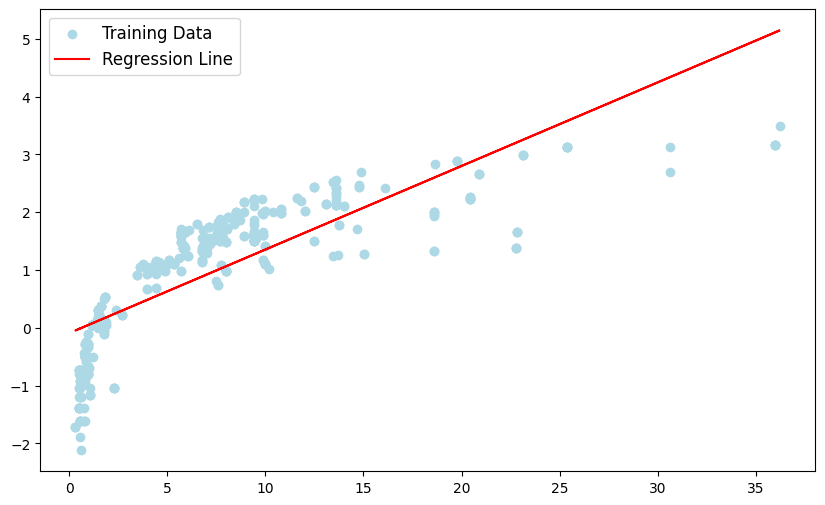

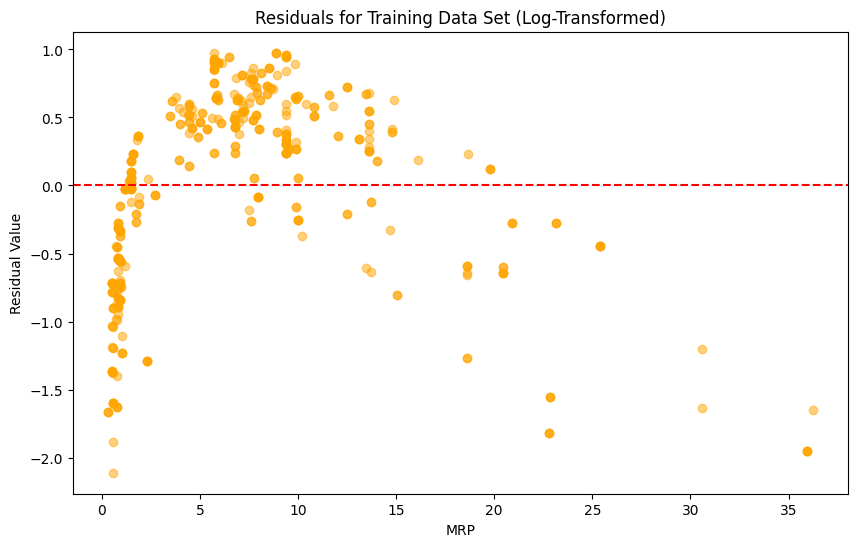

In [116]:
# your code here
# Log-transform the response variable
y_train_log = np.log(y_train)
y_val_log = np.log(y_val)
y_test_log = np.log(y_test)
# Fit a linear regression model to the log-transformed response variable
linreg_log = LinearRegression()
linreg_log.fit(X_train[['MRP']], y_train_log)
# Compute the MSE of the log-transformed model
lin_train_log_mse = mean_squared_error(y_train_log, linreg_log.predict(X_train[['MRP']]))
lin_val_log_mse = mean_squared_error(y_val_log, linreg_log.predict(X_val[['MRP']]))
lin_test_log_mse = mean_squared_error(y_test_log, linreg_log.predict(X_test[['MRP']]))
# Compute the R-squared of the log-transformed model
lin_train_log_r2 = linreg_log.score(X_train[['MRP']], y_train_log)
lin_val_log_r2 = linreg_log.score(X_val[['MRP']], y_val_log)
lin_test_log_r2 = linreg_log.score(X_test[['MRP']], y_test_log) 

print("Log-transformed linear regression model results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        lin_train_log_mse,
        lin_test_log_mse,

    ),
    "\tTrain R-squared\t{:.4f}\n".format(
        lin_train_log_r2,
    ),
    "\test R-squared\t{:.4f}\n".format(
        lin_test_log_r2,
    ),
)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(X_train['MRP'], y_train_log, color='lightblue', label='Training Data')
ax.legend(loc='upper left', fontsize=12, frameon=True)
ax.plot(X_train['MRP'], linreg_log.predict(X_train[['MRP']]), color='red', label='Regression Line')
ax.legend(loc='upper left', fontsize=12, frameon=True)

fig, ax = plt.subplots(figsize=(10, 6))
residuals_log = y_train_log - linreg_log.predict(X_train[['MRP']])
ax.scatter(X_train['MRP'], residuals_log, color='orange', alpha=0.5)
ax.axhline(0, color='red', linestyle='--', label='Zero Residual Line')
ax.set_title('Residuals for Training Data Set (Log-Transformed)')
ax.set_xlabel('MRP')
ax.set_ylabel('Residual Value')

Even after the log transformation, the homoscedasticity issue persists, as the residuals still show clear patterns that indicate that the data doesn't follow a strict linear relationship. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### Q3.2.3

Based on your results, which model would you select as the best for predicting car prices? Justify your choice by comparing their performance on the test set. Is your chosen model a "good" model? Explain why or why not, and discuss any reasons you might have to doubt your choice.

In [117]:
y_test_log_pred = linreg_log.predict(X_test[['MRP']])
lin_test_log_mse = mean_squared_error(y_test_log, y_test_log_pred)
lin_test_log_r2 = r2_score(y_test_log, y_test_log_pred)
y_train_log_pred = linreg_log.predict(X_train[['MRP']])
lin_train_log_mse = mean_squared_error(y_train_log, y_train_log_pred)
lin_train_log_r2 = r2_score(y_train_log, y_train_log_pred)

y_test_pred = linreg.predict(X_test[['MRP']])
lin_test_mse = mean_squared_error(y_test, y_test_pred)
lin_test_r2 = r2_score(y_test, y_test_pred)
y_train_pred = linreg.predict(X_train[['MRP']])
lin_train_mse = mean_squared_error(y_train, y_train_pred)
lin_train_r2 = r2_score(y_train, y_train_pred)

y_test_knn_pred = knn.predict(X_test[['MRP']])
knn_test_mse = mean_squared_error(y_test, y_test_knn_pred)  
knn_test_r2 = r2_score(y_test, y_test_knn_pred) 
y_train_knn_pred = knn.predict(X_train[['MRP']])
knn_train_mse = mean_squared_error(y_train, y_train_knn_pred)
knn_train_r2 = r2_score(y_train, y_train_knn_pred)

model_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Log-Transformed Linear Regression', 'k-NN Regression (k=7)'],
    'Train MSE': [lin_train_mse, lin_train_log_mse, knn_train_mse],
    'Test MSE': [lin_test_mse, lin_test_log_mse, knn_test_mse],
    'Train R-squared': [lin_train_r2, lin_train_log_r2, knn_train_r2],
    'Test R-squared': [lin_test_r2, lin_test_log_r2, knn_test_r2]
})  

model_comparison


,Model,Train MSE,Test MSE,Train R-squared,Test R-squared
0,Linear Regression,4.672,2.915,0.787,0.791
1,Log-Transformed Linear Regression,0.513,0.508,0.643,0.614
2,k-NN Regression (k=7),3.190,2.211,0.855,0.842


The MSE of the Log-transformed model is considerably lower than the MSE of the original linear regression model, indicating that the log-transformed model has better predictive accuracy on the test set and it is also more consistent between training and test sets, this is something that both the Linear regression and the kNN models lack, as they show a large difference between training and test MSE, indicating overfitting on the training data.
However, the R2 value of the log-transformed model is lower than that of the original linear regression model or the kNN model, thus it explains less variance in the response variable.

I would choose the log-transformed model based on its lower MSE if those were the only options available, but I would also consider further exploration of the kNN model with different K values close to the best_k found, as it has a higher R2 value and might be able to achieve a lower MSE with some tuning.



<!-- END QUESTION -->

<a id="part2"></a>
    
# PART 2 [32 pts]: Analysis of 2024 US Annual Social and Economic (ASEC) Supplement

<a id="part2intro"></a>

## Overview

In this part we analyze *simulated* income data from the publically available 2024 US Annual Social and Economic (ASEC) Supplement (https://www.census.gov/data/datasets/time-series/demo/cps/cps-asec.html), provided by the US Census Bureau. The Current Population Survey (CPS) has been conducted monthly for over 50 years. Currently, about 54,000 households are interviewed monthly, scientifically selected on the basis of area of residence to represent the nation as a whole, individual states, and other specified areas. 

### Dataset

The simulated data can be found in `data/census_data.csv`.

The number of features have been greatly reduced from the original dataset. You can see the description of the original dataset in the [ASEC data dictionary](https://www2.census.gov/programs-surveys/cps/datasets/2024/march/asec2024_ddl_pub_full.pdf).

In addition to subsetting the features, other preprocessing steps have been taken. For example, some categorical variables have had their number of unique values reduced. 

We refer to the data as *simulated* because sampling was used to turn what was originally an ordinal response variable (42 income brackets) into something more continous.

Considering this, the results of your analysis should be viewed skeptically. You can view the the preprocessing steps taken to create the simplified, simulated data in `data/preprocessing.ipynb`.

**NOTE:** Variables have been renamed for easier interpretation. You can find the original variable names in the preprocessing notebook. It will be these original variable names that appear in the data dictionary linked above.

### Features
- **age** - Age of person 
- **hourly_pay** - Hourly salary of person (-1 if person is not payed by the hour)
- **hours_per_week** - Number of hours usually worked per week
- **weeks_worked** - Number of weeks worked per year

- **sex** - {'Female': 0,'Male': 1} 
- **marital_status** - {'married':0,'widowed':1,'Divorced':2, 'Separated':3,'Never married':4}
- **military_service** - {'has not served in the US armed forces':0,'has served in the US armed forces':1}
- **student_status** - {'Not currently studying':0,'Enrolled full-time':1, 'Enrolled part-time':1}
- **education** - {'Not finished high school': 0, 'High school': 1, 'Associate degree': 2, 'Bachelor\'s': 3, ,'Master\'s': 4,'Professional school degree': 5', Doctorate': 6}

- **race** - {'White': 0, 'Black': 1, 'American Indian, Alaskan Native only (AI)': 2, 'Asian': 3, ,'Hawaiian, Pacific Islander (HP)': 4,'White-Black': 5', 'White-AI': 6, 'White-Asian': 7, 'White-HP': 8, 'Black-AI': 9, 'Black-Asian': 10, 'Black-HP': 11, 'AI-Asian': 12, 'AI-HP': 13, 'Asian-HP': 14, 'other race combinations': 15}

- **industry** - Industry that the person is working in {'Other': 0, 'Agriculture, forestry, fishing, hunting': 1, 'Mining': 2, 'Construction': 3, ,'Manufacturing': 4,'Wholesale and retail trade': 5','Transportation and utilities': 6, 'Information': 7, 'Financial activities': 8, 'Professional and business services': 9, 'Education and health services': 10, 'Leisure and hospitality': 11, 'Other services': 12, 'Public administration': 13, 'Armed Forces': 14}

- **occupation** - Occupation of person {'Other': 0, 'Management, business, and financial occ.': 1, 'Professional and related occ.': 2, 'Service occ.': 3, ,'Sales and related occ.': 4,'Office and administrative support occ.': 5','Farming, fishing and forestry': 6, 'Construction and extraction occ.': 7, 'Installation, maintenance and repair occ.': 8, 'Production occ.': 9, 'Transportation and material moving occ.': 10, 'Armed Forces': 11}


- **income** - Annual income in dollars

<a id="part4questions"></a>

## Question 4: Investigating trends [18 pts]

Below we'll answer questions about potential trends in the data with the help of plots and/or simple statistics. Your goal should be to communicate your findings clearly. So be sure to provide an interpretation with your visualizations or other output.

In [118]:
df = pd.read_csv("data/census_data.csv", index_col=0)
df.head()

,age,weeks_worked,hours_per_week,hourly_pay,student_status,education,marital_status,sex,military_service,race,industry,occupation,is_paid_by_hour,person_record,income
0,85,0,0,-1,0,1,0,0,0,0,0,0,0,2,9028.04
1,85,0,0,-1,0,1,0,1,1,0,0,0,0,2,23728.07
3,53,0,0,-1,0,1,0,0,0,0,0,0,0,2,11747.51
4,52,52,42,-1,0,1,0,1,0,0,5,5,0,2,40486.23
5,68,0,0,-1,0,0,1,1,0,0,0,0,0,2,9436.61


<!-- BEGIN QUESTION -->

### Q4.1

Is there a disparity in income of participants by gender? Consider using a log scale or another technique when plotting to communicate findings more clearly.

Just by looking at the data with no other variables is hard to determine if there is a disparity in income, while the male population has a higher range of income, it's also true that female income distribution is more equally distributed, with a higher density in the middle range. and shows a higher median income. This could indicate that the male population has outliers with very high income, but also a larger proportion of low-income individuals.

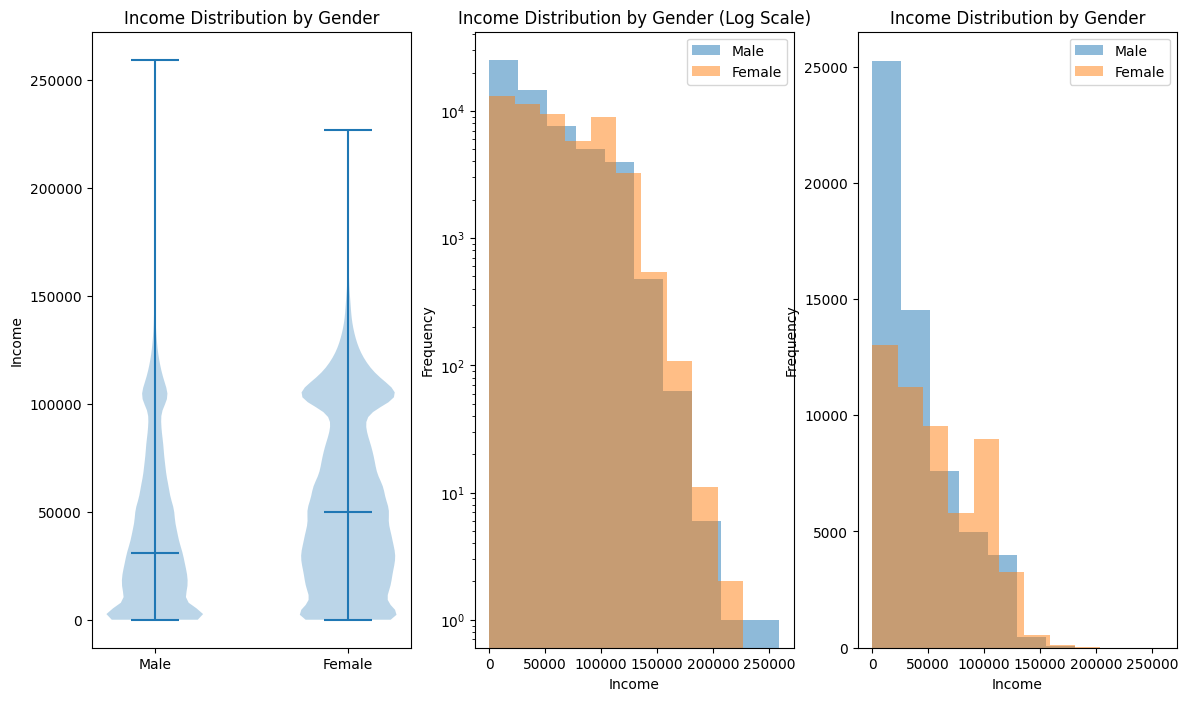

In [119]:
# Income distribution by gender
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 8))
ax[0].violinplot([df[df['sex']==0]['income'], df[df['sex']==1]['income']],
               showmeans=False, showmedians=True)
ax[0].set_xticks([1, 2])
ax[0].set_xticklabels(['Male', 'Female'])
ax[0].set_title('Income Distribution by Gender')
ax[0].set_ylabel('Income')

ax[1].hist(df[df['sex']==0]['income'], alpha=0.5, label='Male', log=True)
ax[1].hist(df[df['sex']==1]['income'], alpha=0.5, label='Female', log=True)
ax[1].set_title('Income Distribution by Gender (Log Scale)')
ax[1].set_xlabel('Income')
ax[1].set_ylabel('Frequency')
ax[1].legend() 

ax[2].hist(df[df['sex']==0]['income'], alpha=0.5, label='Male')
ax[2].hist(df[df['sex']==1]['income'], alpha=0.5, label='Female')
ax[2].set_title('Income Distribution by Gender')
ax[2].set_xlabel('Income')
ax[2].set_ylabel('Frequency')
ax[2].legend()  


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q4.2

Let's investigate a few questions about education and income:
- Is there a relationship between income and education level? 

- Is this trend similar across both genders in the dataset? 

- Is it possible to consider education level as an ordinal variable? For instance, consider whether retaining the numerical ordering in the dataset might be preferable to education level as a categorical variable lacking order.

There is a clear relationship between income and education level, as the education level increases, the income also tends to increase. The higher the education level, the higher the median income and the wider the range of income, indicating that individuals with higher education levels have generally higher earning potential.

The trend is somewhat consistent across both male and female populations, although the distribution of income within each gender group varies, it's important to note that the trend seems to be stronger on the male side, master's and above education levels show diminished returns on income on the female sample.

Given the clear ordering of education levels and their relationship with income, it is reasonable to consider education level as an ordinal variable. The numerical ordering captures the progression of educational attainment and its impact on income but should be used cautiously, as it may introduce assumptions about the spacing between levels that may not be accurate.

/var/folders/7y/06pdt64s53v9wq8m7x1skw_h0000gq/T/ipykernel_29123/1679674530.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels([k for k, v in education_levels.items() if v in df['education'].values], rotation=45)
/var/folders/7y/06pdt64s53v9wq8m7x1skw_h0000gq/T/ipykernel_29123/1679674530.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels([k for k, v in education_levels.items() if v in df['education'].values], rotation=45)
/var/folders/7y/06pdt64s53v9wq8m7x1skw_h0000gq/T/ipykernel_29123/1679674530.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels([k for k, v in education_levels.items() if v in df['education'].values], rotation=45)


Text(0, 0.5, 'Income')

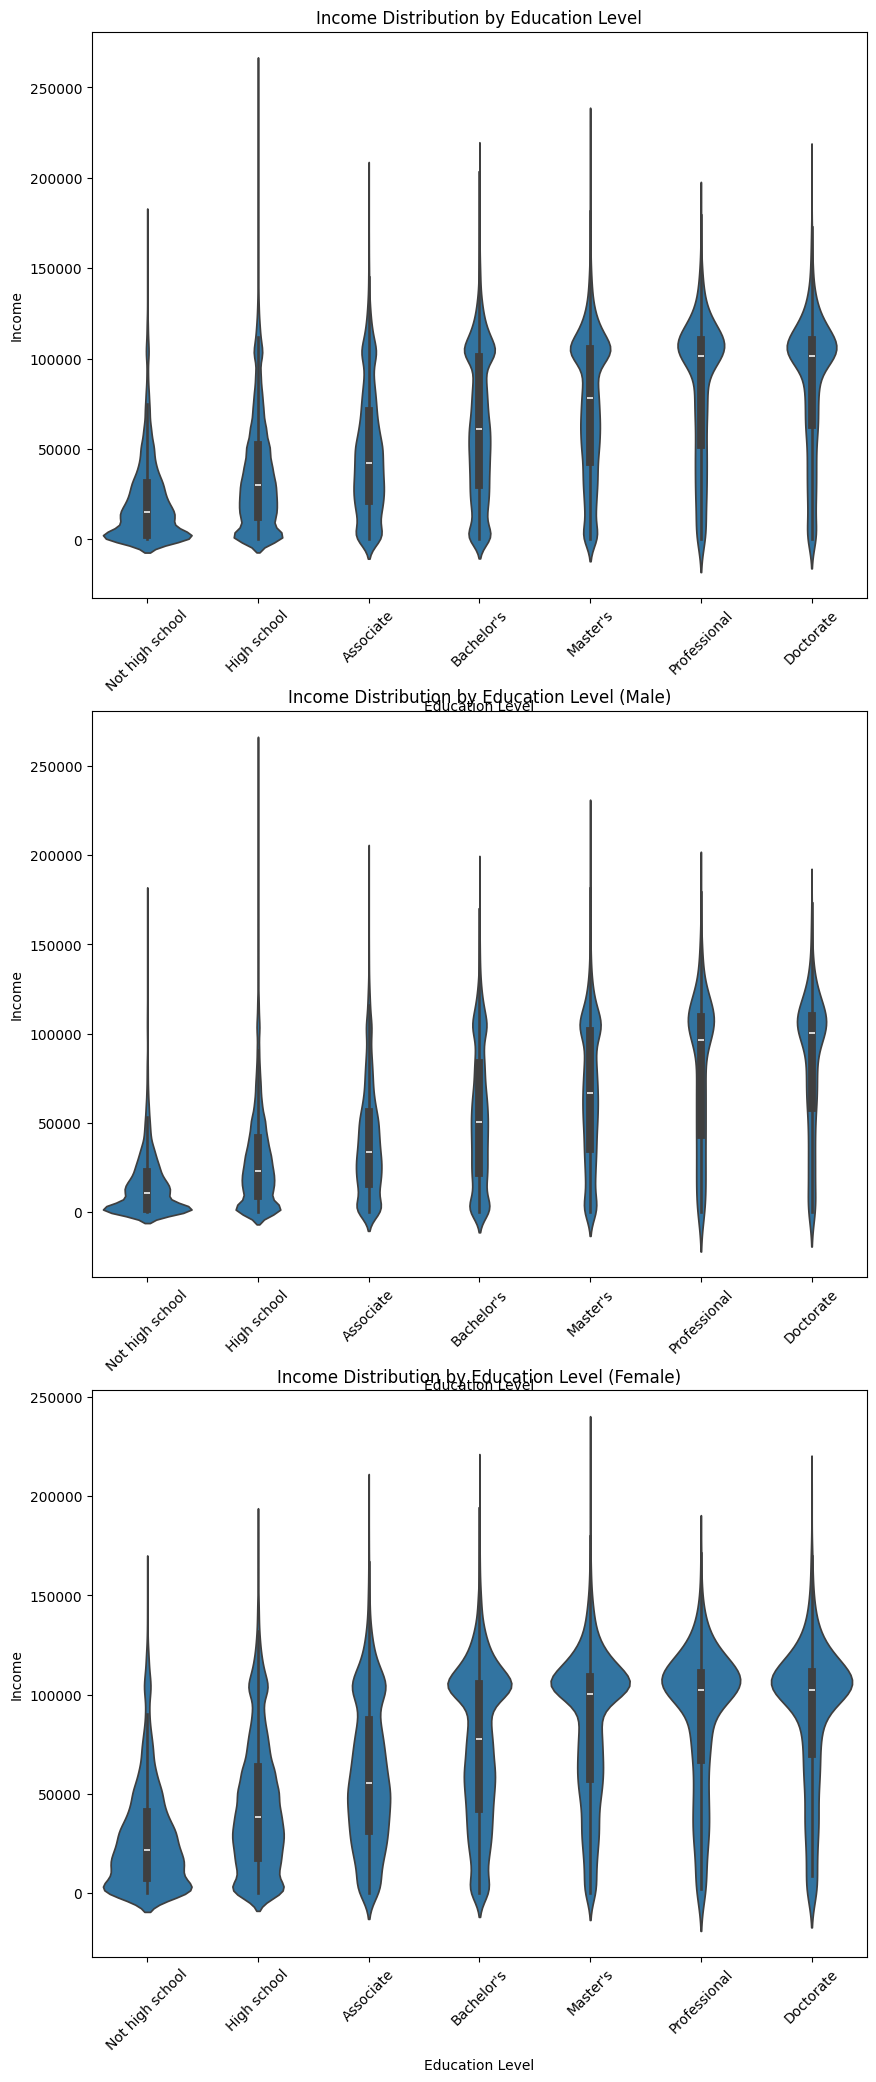

In [120]:
fig, ax = plt.subplots(nrows=3, figsize=(10, 25))
education_levels = {'Not high school': 0, 'High school': 1, 'Associate': 2, 'Bachelor\'s': 3, 'Master\'s': 4, 'Professional': 5, 'Doctorate': 6}
sns.violinplot(x='education', y='income', data=df, ax=ax[0])
ax[0].set_xticklabels([k for k, v in education_levels.items() if v in df['education'].values], rotation=45)
ax[0].set_title('Income Distribution by Education Level')
ax[0].set_xlabel('Education Level')
ax[0].set_ylabel('Income')
sns.violinplot(x='education', y='income', data=df[df['sex']==0], ax=ax[1])
ax[1].set_xticklabels([k for k, v in education_levels.items() if v in df['education'].values], rotation=45)
ax[1].set_title('Income Distribution by Education Level (Male)')
ax[1].set_xlabel('Education Level')
ax[1].set_ylabel('Income')
sns.violinplot(x='education', y='income', data=df[df['sex']==1], ax=ax[2])
ax[2].set_xticklabels([k for k, v in education_levels.items() if v in df['education'].values], rotation=45)
ax[2].set_title('Income Distribution by Education Level (Female)')
ax[2].set_xlabel('Education Level')
ax[2].set_ylabel('Income')

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q4.3

Is there a clear trend between age and income?

- The income appears to be higher between the ages of 30 to 60, we could make an educated guess that this corresponds to individuals who are part of the more experienced working class but haven't retired.

/var/folders/7y/06pdt64s53v9wq8m7x1skw_h0000gq/T/ipykernel_29123/2619762732.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


Text(0, 0.5, 'Income')

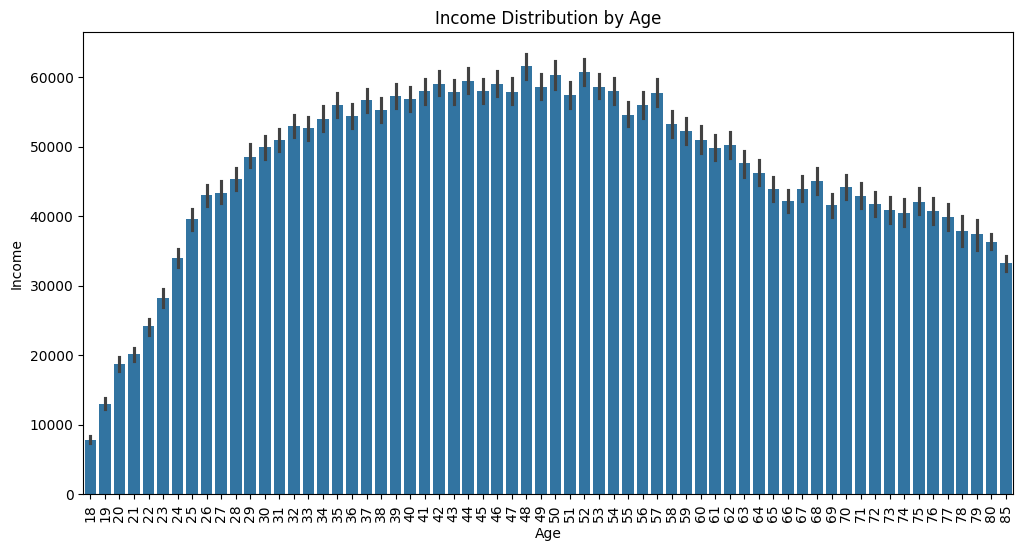

In [121]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='age', y='income', data=df, ax=ax)
ax.set_title('Income Distribution by Age')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('Age')
ax.set_ylabel('Income')

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q4.4

Do any of the quantitative attributes show a clear relationship with income? If so, are these relationships linear or non-linear?

- The weeks worked per year shows a linear relationship with income, as the number of weeks worked increases, the income also tends to increase.
- The relationship of hours per week and hourly pay with income is not as clear, while there could be a positive trend it's not as evident as with weeks worked and the data is more scattered. On both cases the trend seems to be broken at the higher end of the income range of the data. And the hourly pay has a lot of hourly rates at 0, which could be a miscoding issue.


Text(0, 0.5, 'Income')

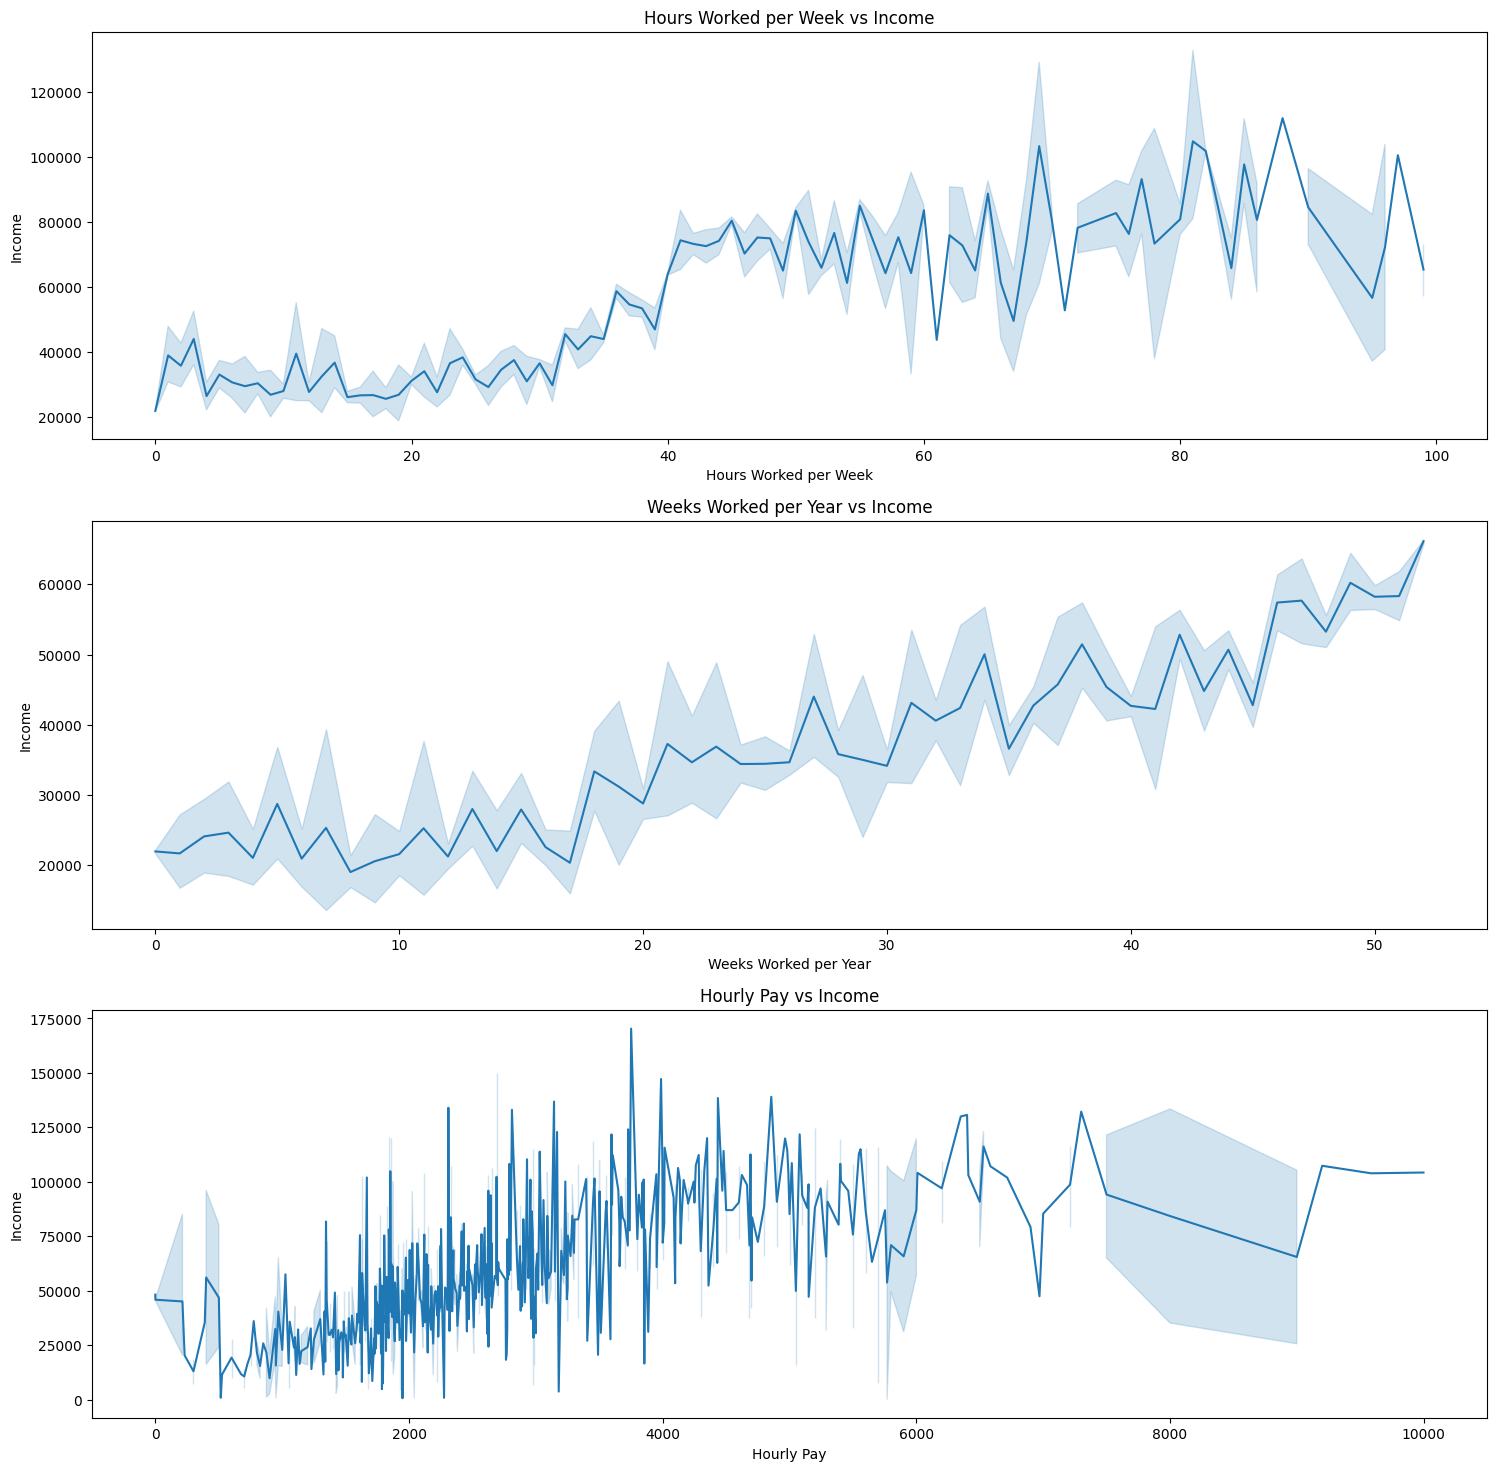

In [122]:
# your code 
# hours per week vs income and workhours
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(18, 18))


sns.lineplot(x='hours_per_week', y='income', data=df, ax=ax[0])
ax[0].set_title('Hours Worked per Week vs Income')
ax[0].set_xlabel('Hours Worked per Week')
ax[0].set_ylabel('Income')
sns.lineplot(x='weeks_worked', y='income', data=df, ax=ax[1])
ax[1].set_title('Weeks Worked per Year vs Income')
ax[1].set_xlabel('Weeks Worked per Year')
ax[1].set_ylabel('Income')

sns.lineplot(x='hourly_pay', y='income', data=df, ax=ax[2])
ax[2].set_title('Hourly Pay vs Income')
ax[2].set_xlabel('Hourly Pay')
ax[2].set_ylabel('Income')


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q4.5

Fit a simple linear regression model to explore the relationship between `military_service` and `income`. Based on your model, what is the estimated average difference in income for those with prior military service? What are some important limitations to consider when interpreting this result?

The average difference in income for those with prior military service is approximately $12k annually. This model suggests that having military experience is associated with higher income, but it's important to consider that other variables are not accounted for in this simple model, such as education level, age, or occupation, which could also influence income. Additionally, the binary nature of the military_service variable does not capture the diversity roles and experiences within military service that could impact income differently.

In [123]:
import matplotlib.scale as ScaleBase

military_linear = LinearRegression()
military_linear.fit(df[['military_service']], df['income'])

military_slope = military_linear.coef_[0]
military_intercept = military_linear.intercept_


print(f"Intercept: {military_intercept:.4f}\n Slope of the fitted linear model\t{military_slope:.4f}")



Intercept: 46658.3748
 Slope of the fitted linear model	12165.7181


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q4.6

Propose a question of your own that you would like to explore in the data. Create a visualization to help you answer this question and provide an interpretation of your findings.

Is there a visible low cap on income based on industry?
- Yes, Armed forces shows a clear lower cap on income compared to all other industries.
What are the industries with the highest and lowest median income?
- Mining is the industry with the highest median income, while Other has the lowest median income.
Are there industries predominantly represented by male or female workers?
- Yes, certain industries like Construction and Mining are predominantly male, while Education and Health Services have a higher representation of female workers.

Does marital status have an impact on income?



/var/folders/7y/06pdt64s53v9wq8m7x1skw_h0000gq/T/ipykernel_29123/3793298097.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([industry_categories.get(int(label.get_text()), label.get_text()) for label in ax.get_xticklabels()], rotation=45, horizontalalignment='right')
/var/folders/7y/06pdt64s53v9wq8m7x1skw_h0000gq/T/ipykernel_29123/3793298097.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([industry_categories.get(int(label.get_text()), label.get_text()) for label in ax.get_xticklabels()], rotation=45, horizontalalignment='right')
/var/folders/7y/06pdt64s53v9wq8m7x1skw_h0000gq/T/ipykernel_29123/3793298097.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Married", "Wido

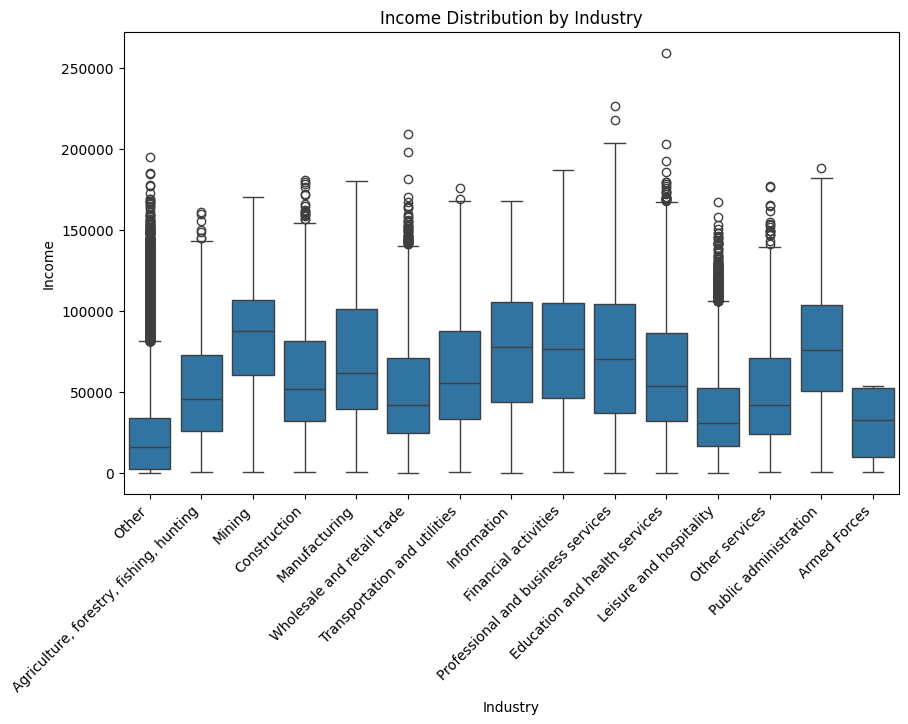

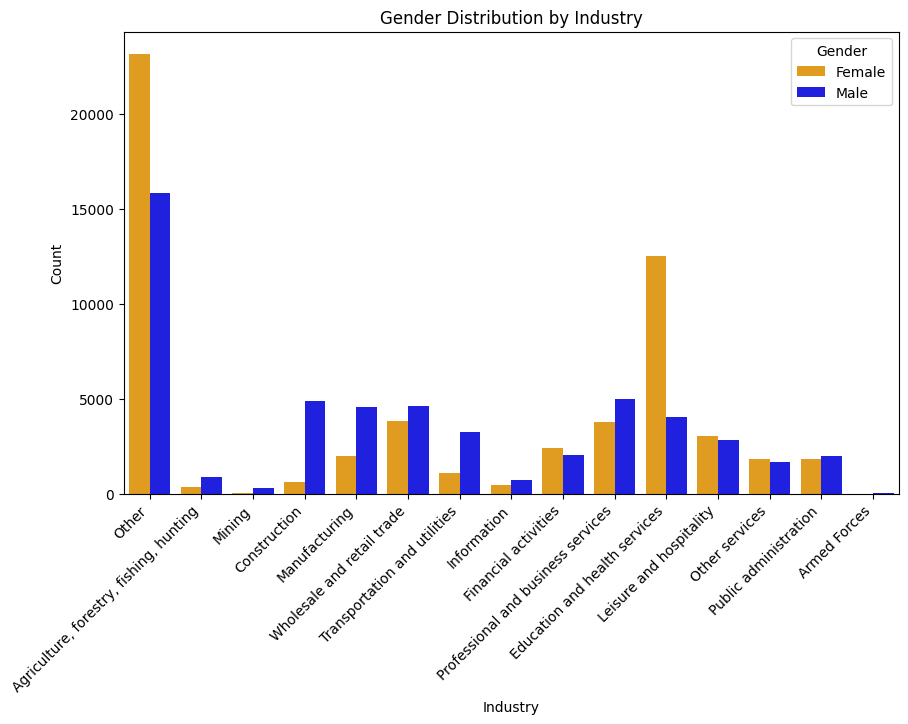

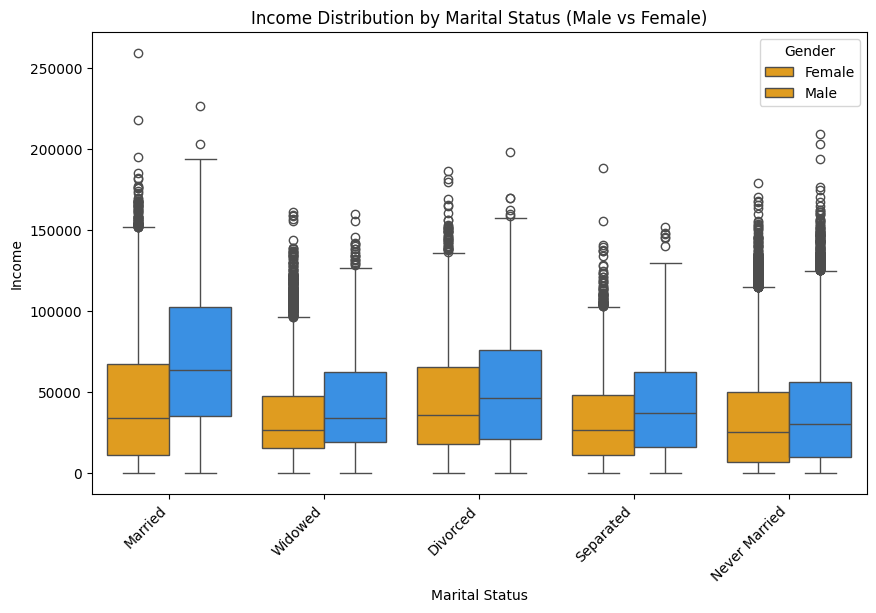

In [124]:
industry_categories = {0: "Other",  1 :'Agriculture, forestry, fishing, hunting', 2: 'Mining', 3: 'Construction', 4: 'Manufacturing', 5: 'Wholesale and retail trade', 6: 'Transportation and utilities', 7: 'Information', 8: 'Financial activities', 9: 'Professional and business services', 10: 'Education and health services', 11: 'Leisure and hospitality', 12: 'Other services', 13: 'Public administration', 14: 'Armed Forces'}
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='industry', y='income', data=df, ax=ax)
ax.set_title('Income Distribution by Industry')
ax.set_xticklabels([industry_categories.get(int(label.get_text()), label.get_text()) for label in ax.get_xticklabels()], rotation=45, horizontalalignment='right')
ax.set_xlabel('Industry')
ax.set_ylabel('Income')

# Male/female distribution by industry
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x='industry', hue='sex', data=df, ax=ax, palette={0: 'orange', 1: 'blue'})
ax.set_title('Gender Distribution by Industry') 
ax.set_xticklabels([industry_categories.get(int(label.get_text()), label.get_text()) for label in ax.get_xticklabels()], rotation=45, horizontalalignment='right')
ax.set_xlabel('Industry')
ax.set_ylabel('Count')
ax.legend(title='Gender', labels=['Female', 'Male'])


fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='marital_status', y='income', hue='sex', data=df, ax=ax, palette={0: 'orange', 1: 'dodgerblue'}, legend= False)
ax.set_title('Income Distribution by Marital Status (Male vs Female)')
ax.set_xticklabels(["Married", "Widowed", "Divorced","Separated", "Never Married"], rotation=45, horizontalalignment='right')
ax.set_xlabel('Marital Status')
ax.set_ylabel('Income')
legend =ax.legend(title='Gender', labels=['Female', 'Male'])




<!-- END QUESTION -->

<a id="part5questions"></a>

## Question 5: Calculate the Gini coefficient [8 pts]


**Gini coefficients are often used to quantify income inequality.** For an introductory overview of the Gini coefficient, its derivation, and its uses, you can [read more about it here](https://en.wikipedia.org/wiki/Gini_coefficient). That article also provides [a useful graphical representation](https://en.wikipedia.org/wiki/File:Economics_Gini_coefficient2.svg) of the Gini coefficient to better understand how it measures inequality. 

The Gini coefficient is defined by the formula:

$$G = \dfrac{ \sum_{i=1}^{n} (2i - n - 1) x_i}{n  \sum_{i=1}^{n} x_i}$$

where $x$ is an observed value, $n$ is the number of values observed and $i$ is the rank of values in **ascending** order.

A Gini coefficient of $G=0$ implies perfect income equality, whereas a Gini coefficient close to $G=1$ implies a concentration of wealth among the richest few.

### Q5.1

Based on the above formula, calculate and report the Gini coefficient for the income of those people in the the provided ASEC dataset. Store the result in `gini_coef`.

- **NOTE:** For algorithmic simplicity and consistency, you can rank income values for all observations, keeping duplicate values in your sorted array. Therefore, you will likely have sorted income values $x_i$ similar to `[417, 417, 417, ..., 250000, 250000, 250000]` with corresponding rank indices $i$ similar to `[1, 2, 3, ..., 12353, 12354, 12355]`. Nothing more sophisticated than that is required for dealing with ties (i.e. duplicates) in your sorted income values for Question 5.1.

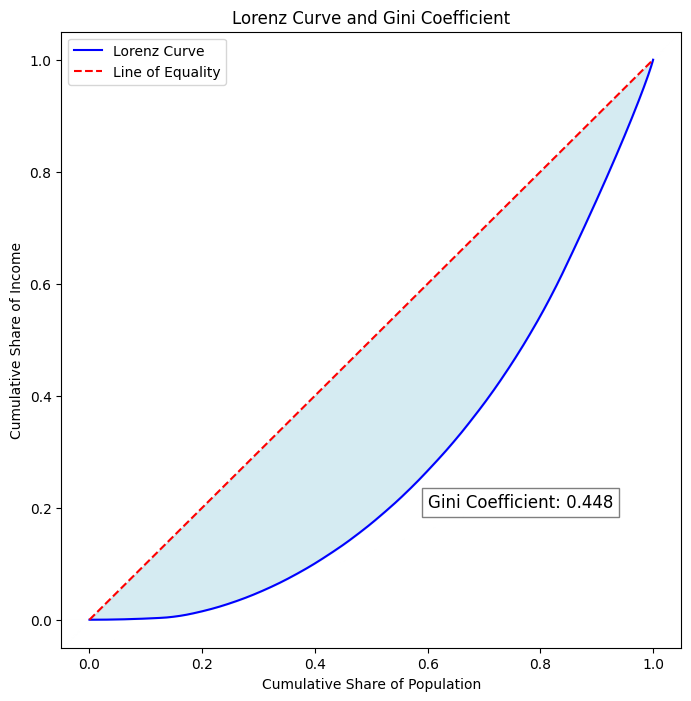

In [125]:



def gini_coefficient(data: np.ndarray) -> float:

    if np.any(data < 0):
        raise ValueError("Input values must be non-negative for Gini coefficient calculation.")
    n = len(data)
    if n == 0:
        return 0.0
    if n == 1:
        return 0.0 # Gini is 0 if there's only one value
    # Ensure the array is sorted (if not already)
    data = np.sort(data)

    # Calculate the Gini coefficient using the formula
    numerator = np.sum((2 * np.arange(1, n + 1) - n - 1) * data)
    denominator = n * np.sum(data)

    if denominator == 0:
        return 0.0 # Handle cases where all values are zero
    
    return numerator / denominator



data = df['income'].to_numpy()
sorted_data = np.sort(data)
gini_perfect_equality = gini_coefficient(sorted_data)

# your code here
gini_coef = gini_coefficient(sorted_data)

fig, ax = plt.subplots(figsize=(8, 8))
# Plot the Lorenz curve
sorted_data = np.sort(data)
cumulative_data = np.cumsum(sorted_data)
cumulative_data = cumulative_data / cumulative_data[-1]  # Normalize to [0, 1]
cumulative_population = np.arange(1, len(data) + 1) / len(data)
ax.plot(cumulative_population, cumulative_data, label='Lorenz Curve', color='blue')
ax.plot([0, 1], [0, 1], label='Line of Equality', color='red', linestyle='--')
ax.fill_between(cumulative_population, cumulative_data, cumulative_population, color='lightblue', alpha=0.5)
ax.set_title('Lorenz Curve and Gini Coefficient')
ax.set_xlabel('Cumulative Share of Population')
ax.set_ylabel('Cumulative Share of Income')
ax.legend()
ax.text(0.6, 0.2, f'Gini Coefficient: {gini_coef:.3f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.show()


In [126]:
# Print resulting Gini coefficient
print(f"The Gini Index for this dataset is {gini_coef:.3f}")

The Gini Index for this dataset is 0.448


In [127]:
grader.check("q5.1")

q5.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

### Q5.2

According to the [World Bank estimate](https://www.indexmundi.com/facts/indicators/SI.POV.GINI/rankings) the country with the largest Gini coefficient is South Africa, ranked 1st at $0.63$, while the lowest is the Slovak Republic, ranked 162nd at $0.232$. The United States is ranked 46th on the list and has a Gini index of $0.415$.

- How well does your calculated Gini coefficient for this simulated dataset match the world bank estimate?

- Might the self-report nature of the data, preprocessing steps, or simulation (i.e., sampling) procedure have affected your results? If so, how?

**Note:** The World Bank estimate website uses a [0,100] range for the Gini Index. Above we have converted this to a [0,1] range.

- The Gini coefficient for the dataset is 0.481, which represents higher income inequality compared to the United States Gini coefficient of 0.415. Showing that the simulated data might have a higher concentration of wealth among the richest few compared to the actual US population.

- The sampling procedure used may have introduced bias and may not represent the population accurately. Additionally, self-reported income data can be unreliable due to underreporting or overreporting, which can also affect the accuracy of the Gini coefficient. The preprocessing could have skewed the income distribution, especially if outliers were removed or if income brackets were simplified.


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<a id="part6questions"></a>

## Question 6: Critiquing the simulated data [6 pts]

Take a look at both the [data dictionary for the original dataset](https://www2.census.gov/programs-surveys/cps/datasets/2024/march/asec2024_ddl_pub_full.pdf) and the notebook used to create the simplified simulation, `data/preprocessing.ipynb`. 

What might you have done differently were you to write your own preprocessing code?

A nonexhaustive list of a few things to consider would be:
- Are there important features you think should have been included that were not? 
    Yes, features like "SEOTR" (self-employment income), "DIS_VAL"(1 and 2) (disability income), and "DST_VAL"(and its subcategories) (pension income) could provide a more comprehensive view of an individual's income sources.
    
    GTCBSASZ, GTCSA, GTINDVPC, GTMETSTA All contain relevant geographic information that could be useful for understanding income disparities across different regions and allow to analyze urban vs rural income differences.

    Other datasets from the CPS, like the basic monthly survey could also provide additional context, like the number of jobs the person has. Multiple part-time jobs, more than one full-time job, or gig work directly affects income but might not be fully captured by the current features.
    Splitting income into its components could enable the analysis of how different income sources contribute to overall income inequality. 

    The PTOT_R Coding may need to be re-evaluated as it combines all earnings over 100k into a single category, this obscures important variations in high-income earners and according to a quick search, it consists of about 18% of the population, which is a significant portion of the dataset. It may have been a good encoding to represent the data in the past, but with the wealth distribution becoming more skewed, and the inflation in the last decade, it may be worth reconsidering this encoding. This is beyond the scope of this assignment, and certainly not responsibility of the authors of the preprocessing code but it is worth mentioning.
    Considering this, switching to PTOTVAL would eliminate the need for simulating income within brackets, as it is a continuous variable with the numerical income value.


- Do you agree with the methods used to reduce the number of unique categorical values?
    The methods used to reduce the number of unique categorical values seem reasonable.
    - Reducing the specificity of racial categories to broader groups can help in analysis by ensuring sufficient sample sizes within each category, given that the dataset is self-reported, the accuracy of the more complex racial categories could be questionable. The reduced categories still capture the major racial groups while simplifying the analysis.
    - The reduction of marital status categories seems appropriate, but it could also be argued that grouping all married categories while leaving widowed, divorced, separated as distinct categories might introduce some bias. I'd suggest doing some exploratory data analysis on the original categories to see if there are significant patterns that justify keeping or merging certain categories.

    - Education level reduction seems reasonable, as the original categories were quite granular. Specially on the lower levels of education and most employers would require a high school diploma as a minimum, so the distinction between not finishing high school and having a high school diploma is important. The higher education levels are also well represented in the reduced categories.
    


- Might there be a better way to simulate a continuous response from the discrete income brackets in the original data?
    The method used assumes an even distribution of income within each bracket, which may be unrealistic. It does great at keeping the representation of each bucket by creating an entry per occurence within the bucket.
    The representation within the brackets could improve if we used fitted models to estimate the distribution of income within each bracket, rather than assuming a uniform distribution.




**Note:** We used the record type 'person' data from the ASEC rather than 'household' or 'family.' All three record types are represented in the data dictionary.

> **Note**: The rubric below is provided for transparency. Please ensure your responses are genuine and thoughtful, rather than simply attempting to "fit" the rubric.
---
<details>
<summary><b>Click to view the Q6 Critique Rubric</b></summary>
    
### Q6 Critique Rubric:

**Total Points: 10**

#### 1. Relevance of Comments (4 points):
- **4 points**: The critique directly addresses specific sections or steps in the preprocessing notebook, demonstrating a thorough understanding of the content.
- **3 points**: The critique references multiple sections of the notebook with some specificity.
- **2 points**: The critique generally addresses the notebook but may lack specific references to steps or sections.
- **1 point**: The critique provides only a cursory overview without specific details.
- **0 points**: The critique does not address the preprocessing notebook.

#### 2. Depth of Analysis (4 points):
- **4 points**: The student provides deep insights, identifies potential pitfalls, or suggests meaningful improvements for multiple sections of the notebook.
- **3 points**: The student provides valuable feedback for one section or multiple but less detailed feedback for several sections.
- **2 points**: The analysis is somewhat detailed but may lack depth or actionable feedback.
- **1 point**: The feedback is generic or surface-level.
- **0 points**: No meaningful analysis provided.

#### 3. Clarity and Organization (2 points):
- **2 points**: The critique is well-organized, clear, and easy to follow.
- **1 point**: The critique is somewhat organized but may have unclear sections.
- **0 points**: The critique is disorganized or difficult to understand.

---

Remember to provide specific examples or suggestions whenever possible. General statements without backing evidence or examples will not be as valuable as those with clear references and reasoning.

</details>

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<a id="part3"></a>
    
# PART 3 [33 pts]: Predicting percentage change in bacteria populations given their spread factor

<a id="part3intro"></a>

## Overview

For this part, we will explore polynomial regression for modeling a quantitative variable. Specifically, we will model the percent change in a bacteria population after 4 hours as a function of the bacteria's "spreading factor".

**The data set for this problem has already been split for you.** You will find the train and test data sets in the files `data/bacteria_train.csv` and `data/bacteria_test.csv`, respectively.

### Problem Description

We will predict the percentage change in population, given the spreading factor. Thus, we will consider the `Spreading_factor` to be our predictor variable and `Perc_population` to be our response variable. Using mean squared error ($MSE$) as an evaluative criteria, we will explore several different approaches for finding the best fit and most robust polynomial regression for modeling this relationship.

<a id="part7questions"></a>

## Question 7: Guesstimate the polynomial relationship [7 pts]

<!-- BEGIN QUESTION -->

### Q7.1

Generate a well-labeled scatter plot of the data points in the bacteria_train.csv file with the spreading factor on the 
x-axis and the percentage change on the y-axis.

Based on your inspection of the plot, guesstimate the degree of the polynomial you believe would best fit the training while still generalizing well. Store this degree in the variable `guessed_deg`. 

Next, use `PolynomialFeatures()` to generate a design matrices of the guesstimated degree for the train and test data. Store these in `x_poly_train` and `x_poly_test`. 

**Notes:**
- **You don't need to scale your data in this assignment** (you can inspect the data to see why this might not be necessary)
- **You should *not* include a bias in the design matrix you intend to pass to the linear regression's `fit` method.**

(423, 3)
(108, 3)


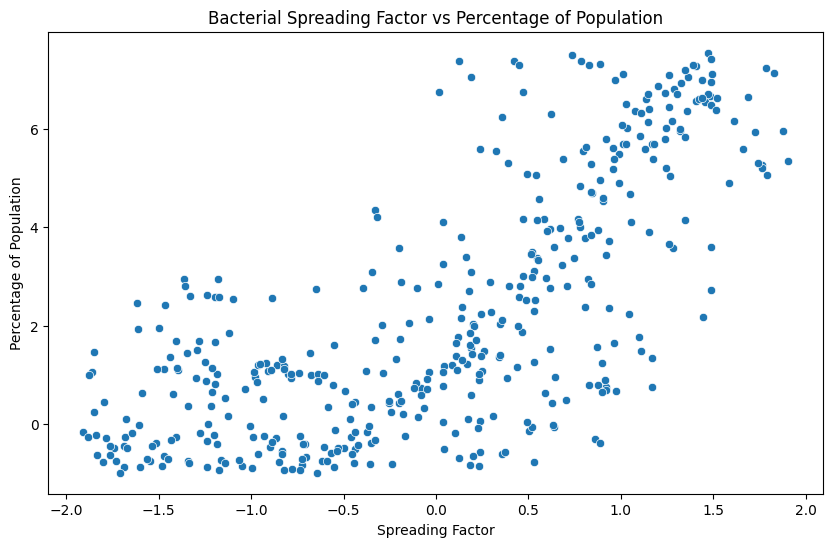

In [128]:
# your code here
df_bact_train = pd.read_csv("data/bacteria_train.csv")
df_bact_test = pd.read_csv("data/bacteria_test.csv")

fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(x='Spreading_factor', y='Perc_population', data=df_bact_train, ax=ax)
ax.set_title('Bacterial Spreading Factor vs Percentage of Population')
ax.set_xlabel('Spreading Factor')
ax.set_ylabel('Percentage of Population')

guessed_deg = 3

x_poly_train = PolynomialFeatures(degree=guessed_deg-1).fit_transform(df_bact_train[['Spreading_factor']])
print(x_poly_train.shape)
x_poly_test = PolynomialFeatures(degree=guessed_deg-1).fit_transform(df_bact_test[['Spreading_factor']])
print(x_poly_test.shape)


In [129]:
grader.check("q7.1")

q7.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

### Q7.2

Fit a polynomial regression using scikit-learn's `LinearRegression()` on the training design matrix. 

To track and compare the performance of each of the models in this notebook, use a list of dictionaries called `results`.

Each dictionary in this list will have the keys: 'model' (a string representing the question number where the model was fit), 'train_mse', and 'test_mse'.

So, for this question, you will append a dictionary to `results` of the form:
```python
{'model': '7.2', 'train_mse': 2.6749 'test_mse': 2.734}
```
Note that your MSE scores will not be the same as those in the example dictionary.

**Hint:** Because you will be calculating MSEs for models through this notebook, you may want to abstract this process into a function for re-use.

In [130]:
# Fit a linear regression model
results = []

# Fit a linear regression model 
linreg_poly = LinearRegression()
linreg_poly.fit(x_poly_train, df_bact_train['Perc_population'])
polyreg7_2 = linreg_poly
train_mse = mean_squared_error(df_bact_train['Perc_population'], linreg_poly.predict(x_poly_train))
test_mse = mean_squared_error(df_bact_test['Perc_population'], linreg_poly.predict(x_poly_test))

results.append({"model": "7.2", "train_mse": train_mse, "test_mse": test_mse})

In [131]:
# Display your results thus far.
pd.DataFrame(results)

,model,train_mse,test_mse
0,7.2,2.662,2.675


In [132]:
grader.check("q7.2")

q7.2 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

### Q7.3

- Create a plot showing both the train and test data, as well as your model's prediction curve.
- Display `results` as a DataFrame.
- Explain the rationale for your choice of degree (i.e. your "guesstimation") and comment on the fit of your model.

The guestimated degree came from visually inspecting the scatterplot of the training data, since the curvature doesn't show changes in direction, a cubic polynomial prevents assuming unnecessary complexity, while still being able to capture the non-linear relationship of the observed data.

<Axes: xlabel='Spreading_factor', ylabel='Perc_population'>

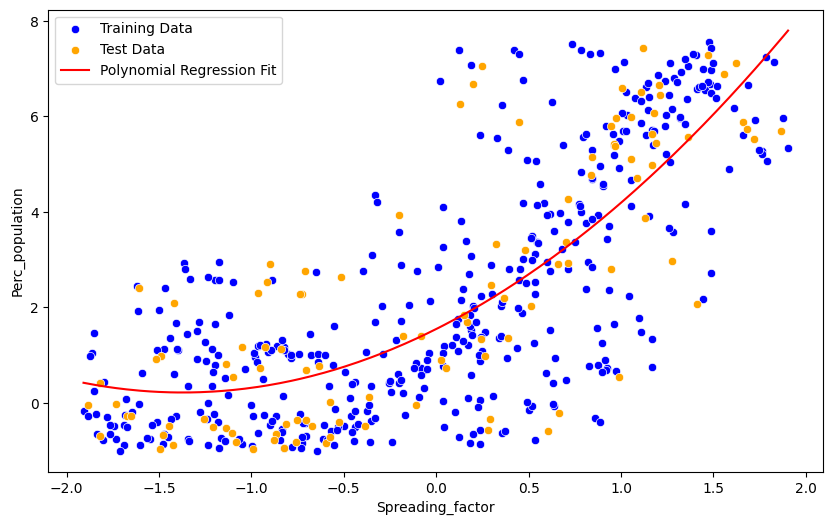

In [133]:
# your code here
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x='Spreading_factor', y='Perc_population', data=df_bact_train, ax=ax, label='Training Data', color='blue')
sns.scatterplot(x='Spreading_factor', y='Perc_population', data=df_bact_test, ax=ax, label='Test Data', color='orange')
sns.lineplot(x=df_bact_train['Spreading_factor'], y=linreg_poly.predict(x_poly_train), ax=ax, label='Polynomial Regression Fit', color='red')


In [134]:
pd.DataFrame(results)


,model,train_mse,test_mse
0,7.2,2.662,2.675


<!-- END QUESTION -->

<a id="part8questions"></a>

## Question 8: Single validation set [12 pts]

In this section you'll find the best degree polynomial relationship using a single validation set.

<!-- BEGIN QUESTION -->

### Q8.1

Split your original training data such that you separate out 20% into a single validation split. Use `random_state=1` and save the resulting splits as `x_train80`, `x_val`, `y_train80`, `y_val`. (This will prevent the overwriting of the original train data variables).

In [135]:
# your code here
x_train80, x_val, y_train80, y_val = train_test_split(df_bact_train[['Spreading_factor']], df_bact_train['Perc_population'], test_size=0.2, random_state=1)

In [136]:
grader.check("q8.1")

q8.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

### Q8.2

- Fit polynomial regression models for **degrees 1 to 30 (inclusive)** on the 80% training set (one model for each degree polynomial regression).
- Store the train and validation MSE values for each model in lists called `train_mses` and `val_mses`.

In [137]:
# your code here
models_82 = []
train_mses = []
val_mses = []
degrees = range(1,31)
for deg in degrees:
    x_poly_train80 = PolynomialFeatures(degree=deg).fit_transform(x_train80)
    x_poly_val = PolynomialFeatures(degree=deg).fit_transform(x_val)
    
    linreg_poly = LinearRegression()
    linreg_poly.fit(x_poly_train80, y_train80)
    
    train_mse = mean_squared_error(y_train80, linreg_poly.predict(x_poly_train80))
    val_mse = mean_squared_error(y_val, linreg_poly.predict(x_poly_val))
    train_mses.append(train_mse)
    val_mses.append(val_mse)
    models_82.append({"degree": deg, "train_mse": train_mse, "val_mse": val_mse})

pd.DataFrame(models_82)

,degree,train_mse,val_mse
0,1,3.027,3.394
1,2,2.583,2.977
2,3,2.580,2.954
3,4,2.473,2.975
4,5,2.473,2.975
5,6,2.464,2.954
6,7,2.463,2.921
7,8,2.428,2.915
8,9,2.427,2.919
9,10,2.425,2.924


In [138]:
grader.check("q8.2")

q8.2 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

### Q8.3

- Generate a single plot illustrating the train and validation $MSE$ values for each fitted degree polynomial regression model.
- Identify and report the degree for which the validation error is lowest.

**Note:** Plotting the MSE on a log scale may be helpful.

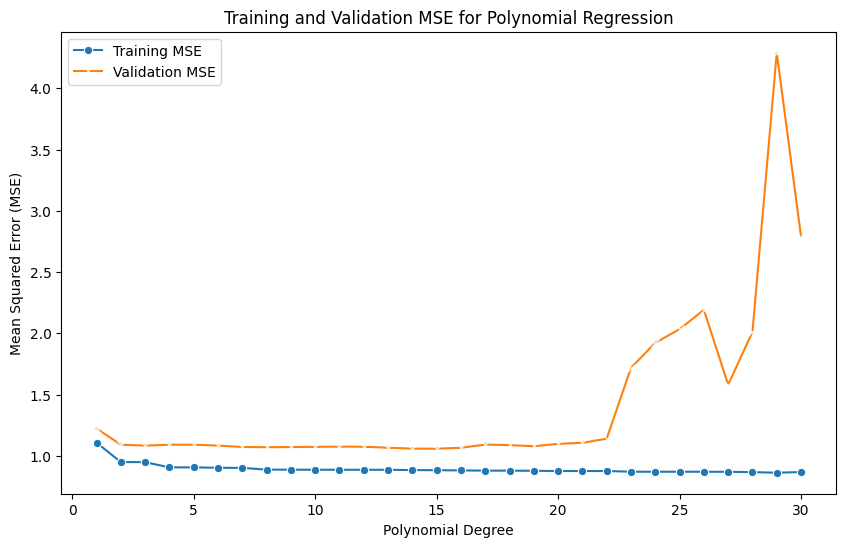

In [139]:
# your code here
train_mses_data = pd.DataFrame(train_mses, columns=['train_mse'], index=degrees)
val_mses_data = pd.DataFrame(val_mses, columns=['val_mse'], index=degrees)
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=np.log(train_mses_data), x=train_mses_data.index, y='train_mse', marker='o', label='Training MSE', ax=ax)
sns.lineplot(data=np.log(val_mses_data), x=val_mses_data.index, y='val_mse', marker='x', label='Validation MSE', ax=ax)
ax.set_xlabel('Polynomial Degree')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('Training and Validation MSE for Polynomial Regression')
ax.legend()




In [140]:
best_val_mse = min(val_mses)
best_degree = degrees[val_mses.index(best_val_mse)]
print(f"The best polynomial degree is {best_degree} with a validation MSE of {best_val_mse:.4f}.")


The best polynomial degree is 15 with a validation MSE of 2.8802.


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q8.4

Now, with the best degree selected, train the polynomial regression on the **complete training set** (including the observations that you had previously removed to make the validation set). 

Append a new dictionary to your `results` list for this model.

In [141]:
# your code here
x_poly_train_full = PolynomialFeatures(degree=best_degree).fit_transform(df_bact_train[['Spreading_factor']])
x_poly_test = PolynomialFeatures(degree=best_degree).fit_transform(df_bact_test[['Spreading_factor']])
linreg_poly_final = LinearRegression()
linreg_poly_final.fit(x_poly_train_full, df_bact_train['Perc_population'])
train_mse_final = mean_squared_error(df_bact_train['Perc_population'], linreg_poly_final.predict(x_poly_train_full))
test_mse_final = mean_squared_error(df_bact_test['Perc_population'], linreg_poly_final.predict(x_poly_test))

results.append({"model": "8.4", "train_mse": train_mse_final, "test_mse": test_mse_final})

In [142]:
# Display your results thus far.
pd.DataFrame(results)

,model,train_mse,test_mse
0,7.2,2.662,2.675
1,8.4,2.491,2.736


In [143]:
grader.check("q8.4")

q8.4 results: All test cases passed!

<!-- BEGIN QUESTION -->

### Q8.5

Generate a plot of the data and your regression curve (similar to [Question 7.3](#part7questions)). Comment on how your model fits the data and compare it to the fit of your "guesstimated" model from Question 7.

Text(0, 0.5, 'Percentage of Population')

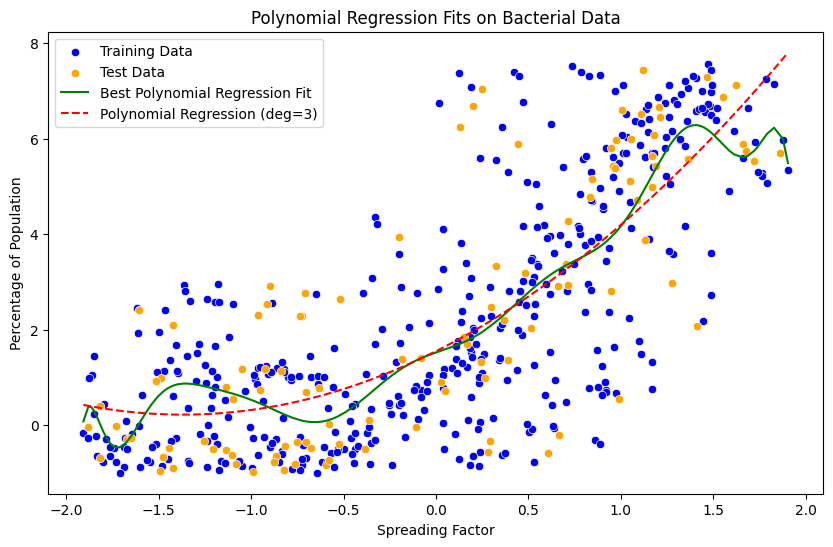

In [144]:
# your code here
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x='Spreading_factor', y='Perc_population', data=df_bact_train, ax=ax, label='Training Data', color='blue')
sns.scatterplot(x='Spreading_factor', y='Perc_population', data=df_bact_test, ax=ax, label='Test Data', color='orange')
sns.lineplot(x=df_bact_train['Spreading_factor'], y=linreg_poly_final.predict(x_poly_train_full), ax=ax, label='Best Polynomial Regression Fit', color='green') 
sns.lineplot(x=df_bact_train['Spreading_factor'], y=polyreg7_2.predict(PolynomialFeatures(degree=guessed_deg-1).fit_transform(df_bact_train[['Spreading_factor']])), ax=ax, label='Polynomial Regression (deg=3)', color='red', linestyle='--')

ax.set_title('Polynomial Regression Fits on Bacterial Data')
ax.set_xlabel('Spreading Factor')
ax.set_ylabel('Percentage of Population')


The initial guess of a cubic polynomial was overly simplistic. The model using the best degree polynomial from the validation set shows a fit that makes sense and depicts the nuances of the data behavior. Guessing can only get you so far, as it introduces significant bias, and it's important to validate assumptions with data.

<a id="part9questions"></a>

## Question 9: Finding the best model by k-fold cross validation [14 pts]

<!-- BEGIN QUESTION -->

### Q9.1

In this part we find the best degree polynomial regression by running the model on a range of degree values and using k-fold cross validation. Note that `cross_validation` should be passed *all* training examples (*not* the 80% split from the previous question).

- Use scikit-learn's `cross_validate(...)` to perform cross validation with $k=10$ for each polynomial regression from **degree 1 to 30 (inclusive)**.
- For each degree:
    - store the mean train MSE across all $k$ folds in the list `train_mses_mean`
    - store the mean validation MSE across all $k$ folds in the list `val_mses_mean`
    - store the standard deviation  of the validation MSE across all $k$ folds in the list `val_mses_std`

In [145]:
# your code here
train_mses_mean = []
val_mses_mean = []
val_mses_std = []
degrees = range(1,31)
for deg in degrees:
    x_poly_train_cv = PolynomialFeatures(degree=deg).fit_transform(df_bact_train[['Spreading_factor']])
    
    linreg_poly = LinearRegression()
    linreg_poly.fit(x_poly_train_cv, df_bact_train['Perc_population'])

    results_cv = cross_validate(
        linreg_poly,
        x_poly_train_cv,
        df_bact_train['Perc_population'],
        cv=10,
        scoring='neg_mean_squared_error',
        return_train_score=True
    )
    
    train_mses_mean.append(-np.mean(results_cv['train_score']))
    val_mses_mean.append(-np.mean(results_cv['test_score']))
    val_mses_std.append(np.std(results_cv['test_score']))

train_data_metrics = pd.DataFrame(train_mses_mean, columns=['train_mse'], index=degrees,)
train_data_metrics = pd.concat([train_data_metrics, pd.DataFrame(val_mses_mean, columns=['val_mse'], index=degrees)], axis=1)
train_data_metrics = pd.concat([train_data_metrics, pd.DataFrame(val_mses_std, columns=['val_mse_std'], index=degrees)], axis=1)

train_data_metrics


,train_mse,val_mse,val_mse_std
1,3.099,3.121,0.594
2,2.660,2.697,0.696
3,2.651,2.699,0.705
4,2.568,2.622,0.794
5,2.568,2.630,0.792
6,2.556,2.629,0.781
7,2.541,2.634,0.761
8,2.508,2.599,0.779
9,2.508,2.612,0.785
10,2.506,2.621,0.786


In [146]:
grader.check("q9.1")

q9.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

### Q9.2

- Generate a single plot showing the mean train and validation $MSE$ values (see note below) for each degree polynomial regression, including the +/- 1 standard deviation bounds for the validation $MSE$ values.
- Comment on trends and findings illustrated by your plot.
- Print the degree of the best model, identified based on the lowest mean validation $MSE$, along with the corresponding mean train and validation $MSE$ values.

**NOTE:** When we refer to train and validation $MSE$ values here in Question 9.2 and in future problems where we are performing cross validation, we are referring specifically to the cross-validation generated train and validation $MSE$ values. Just please remember, when accessing your validation $MSE$ values while performing cross validation with scikit-learn's `cross_validate(...)`, scikit-learn rather confusingly refers to its validation scores as `test_score` in the dictionary that it returns, even though those values are actually validation scores. Please see the `cross_validate(...)` [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) for more info on this function.

_Type your answer here, replacing this text._

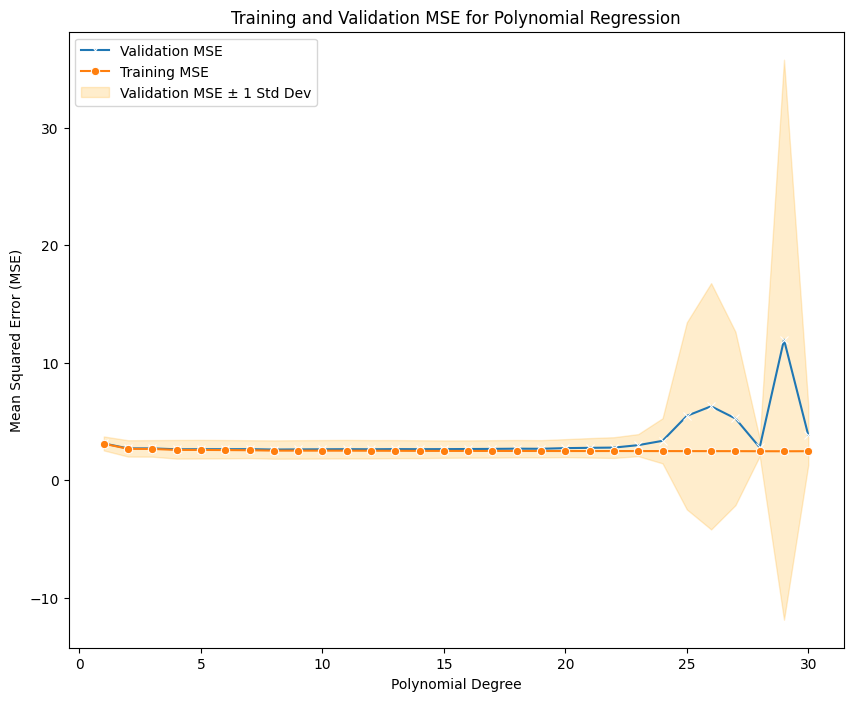

In [147]:
# your code here
#- Generate a single plot showing the mean train and validation $MSE$ values (see note below) for each degree polynomial regression, including the +/- 1 standard deviation bounds for the validation $MSE$ values.

fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(data=train_data_metrics, x=train_data_metrics.index, y='val_mse', marker='x', label='Validation MSE', ax=ax)
sns.lineplot(data=train_data_metrics, x=train_data_metrics.index, y='train_mse', marker='o', label='Training MSE', ax=ax)
ax.fill_between(train_data_metrics.index, 
                train_data_metrics['val_mse'] - train_data_metrics['val_mse_std'], 
                train_data_metrics['val_mse'] + train_data_metrics['val_mse_std'], 
                color='orange', alpha=0.2, label='Validation MSE ± 1 Std Dev')
ax.set_xlabel('Polynomial Degree')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('Training and Validation MSE for Polynomial Regression')
ax.legend()



In [148]:
best_cv_val_mse = min(val_mses_mean)
best_cv_degree = degrees[val_mses_mean.index(best_cv_val_mse)]
print(f"The best polynomial degree from cross-validation is {best_cv_degree} with a validation MSE of {best_cv_val_mse:.4f}.")

The best polynomial degree from cross-validation is 8 with a validation MSE of 2.5991.


The degree is very different from the one found using a single validation set, this shows the importance of using cross-validation to reduce variance and get a more robust estimate of model performance. The model from the previous question is likely overfitting the data.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q9.3

Fit the best model based on the entire training data and report the $MSE$.


- For the best degree polynomial regression identified in Question 9.2 above, train on the complete training data and predict on the test data.
- Append a new dictionary for this model to the `results` list.

In [149]:
# your code here
x_poly_train_cv = PolynomialFeatures(degree=best_cv_degree).fit_transform(df_bact_train[['Spreading_factor']])
x_poly_test = PolynomialFeatures(degree=best_cv_degree).fit_transform(df_bact_test[['Spreading_factor']])

linreg_poly_cv = LinearRegression()
linreg_poly_cv.fit(x_poly_train_cv, df_bact_train['Perc_population'])
train_mse_final = mean_squared_error(df_bact_train['Perc_population'], linreg_poly_cv.predict(x_poly_train_cv))
test_mse_final = mean_squared_error(df_bact_test['Perc_population'], linreg_poly_cv.predict(x_poly_test))

results.append({"model": "9.3", "train_mse": train_mse_final, "test_mse": test_mse_final})
pd.DataFrame(results)

,model,train_mse,test_mse
0,7.2,2.662,2.675
1,8.4,2.491,2.736
2,9.3,2.513,2.613


In [150]:
grader.check("q9.3")

q9.3 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

### Q9.4

- Generate a plot of the data and your regression curve (similar to [Question 7.3](#part7questions)).
- Display the coefficients of your model.
- Display `results` as a DataFrame (there should now be 3 entries).
- Comment on how your model fits the data and how your model compares relative to the prior best-fit model you generated using just a single validation set in [Question 8](#part8questions).

The new model shows a simpler curve, still captures the main trends of the data, but with less changes in direction. Using only observation I was fooled by the second model with a single validation set, and started justifying the trends shown as it showed a very complex curve and a very low MSE I thought it was a good model and that clearly that level of complexity was not obvious from observation alone. This shows the importance of using cross-validation to get a more robust estimate of model performance and avoid overfitting.

Model coefficients for the cross-validated polynomial regression with degree 8:
[ 0.          2.59702778 -1.09486847 -1.18913441  3.48314914  0.65287664
 -1.71300787 -0.11530516  0.24041837]


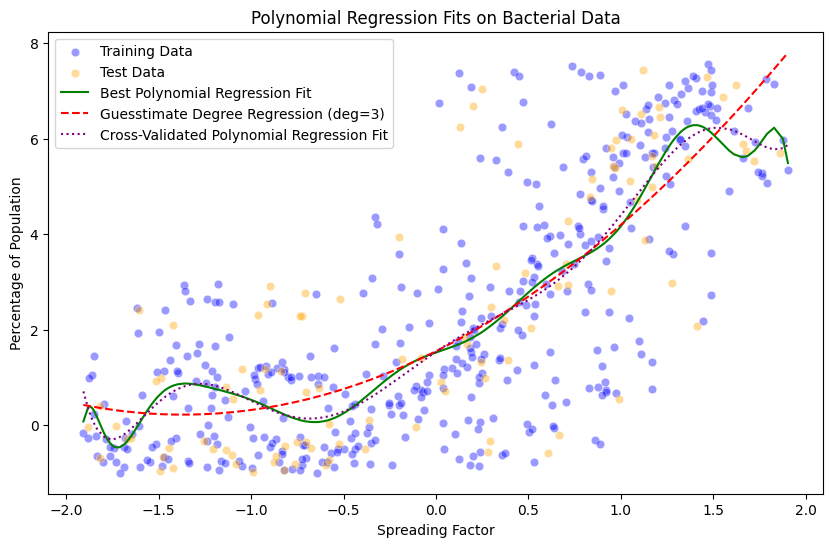

In [151]:
# your code here
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x='Spreading_factor', y='Perc_population', data=df_bact_train, ax=ax, label='Training Data', color='blue', alpha=0.4)
sns.scatterplot(x='Spreading_factor', y='Perc_population', data=df_bact_test, ax=ax, label='Test Data', color='orange', alpha=0.4)
sns.lineplot(x=df_bact_train['Spreading_factor'], y=linreg_poly_final.predict(x_poly_train_full), ax=ax, label='Best Polynomial Regression Fit', color='green') 
sns.lineplot(x=df_bact_train['Spreading_factor'], y=polyreg7_2.predict(PolynomialFeatures(degree=guessed_deg-1).fit_transform(df_bact_train[['Spreading_factor']])), ax=ax, label='Guesstimate Degree Regression (deg=3)', color='red', linestyle='--')
sns.lineplot(x=df_bact_train['Spreading_factor'], y=linreg_poly_cv.predict(x_poly_train_cv), ax=ax, label='Cross-Validated Polynomial Regression Fit', color='purple', linestyle=':')

ax.set_title('Polynomial Regression Fits on Bacterial Data')
ax.set_xlabel('Spreading Factor')
ax.set_ylabel('Percentage of Population')

print(f"Model coefficients for the cross-validated polynomial regression with degree {best_cv_degree}:")
print(linreg_poly_cv.coef_)

In [152]:
pd.DataFrame(results)

,model,train_mse,test_mse
0,7.2,2.662,2.675
1,8.4,2.491,2.736
2,9.3,2.513,2.613


<!-- END QUESTION -->

<div class="alert alert-info" style="color: #4a4a4a; background-color: #fbe8ff; border-color: #eed4db; border-width: 1px; border-radius: 3px; padding: 10px;">

## Wrap-up

* Please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation. This is also a good place to ask any remaining questions you may have.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.

</div>

In [153]:
hours_spent_on_hw = 14

In [154]:
grader.check("wrapup")

wrapup results: All test cases passed!

In [155]:
notebook_end = time.time()
print(f"It took {(notebook_end - notebook_start)/60:.2f} minutes for this notebook to run")

It took 0.19 minutes for this notebook to run


🌈 **This concludes HW2. Thank you!**